# Так закаляем сталь

## Описание

### Задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).



### Описание данных

Данные состоят из файлов, полученных из разных источников:

    * `data_arc.csv`       — данные об электродах;
    * `data_bulk.csv`      — данные о подаче сыпучих материалов (объём);
    * `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
    * `data_gas.csv`       — данные о продувке сплава газом;
    * `data_temp.csv`      — результаты измерения температуры;
    * `data_wire.csv`      — данные о проволочных материалах (объём);
    * `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.



## План работы

1.   Описание проекта
2.   Загрузка данных
3.   Анализ данных
5.   Подготовка данных
6.   Выбор моделей предсказания
7.   Тестирование моделей

## Подготовка

### Библиотеки

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 93 kB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from datetime import datetime, timedelta
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

### Функции

#### column_rename

In [ ]:
def column_rename(data_frame):
    '''
    Функция для замены пробелов и заглавных букв названиях колонок
    '''
    data_frame.columns = data_frame.columns.str.lower().str.replace(' ', '_')
    display(data_frame.columns)

#### column_values_3

In [ ]:
def column_values_3(data_frame):
    '''
    Функция для визуального поиска артефактов и выбросов в значениях DataFrame
    '''
    for column in data_frame.columns:
        print('\nЗначения столбца', column,':')
        print(data_frame[column].sort_values().unique())

#### df_info

In [ ]:
def df_info(data_frame):
    '''
    Функция выводящая первичную информацию о DataFrame
    '''
    print('\nИнфо:')
    print(data_frame.info())                                            # сколько значений и в каком формате
    print('\nПропусков:')
    print(data_frame.isna().mean().sort_values(ascending=False) * 100)  # подсчёт пропусков в процентах
    print('\nОписание:')
    display(data_frame.describe())                                      # вдруг чего "на глазок" проявится 
    print('\nДубликатов =', data_frame.duplicated().sum())              # проверим дубликаты

#### percentage_of_nan

In [ ]:
def percentage_of_nan(data_frame):
    '''
    Функция для визуализации количества пропусков в процентах
    '''
    columns = data_frame.columns.values.tolist()
    nan = []

    for col in columns:
      not_nan_count = data_frame[col].count()
      percent = ((len(data_frame) - not_nan_count) / len(data_frame)) * 100
      nan.append(percent)

    nan_percent_before = pd.Series(nan,
                                   index = columns)
    nan_percent_before_mean = nan_percent_before.mean()
    nan_percent_before.sort_values(ascending = True,
                                   inplace = True)

    fig, ax = plt.subplots(figsize = (12, 8))
    ax.barh(nan_percent_before.index,
            nan_percent_before.values)
    ax.set_title('Процент пропусков значений по столбцам')

    # Добавим на график цифры значений
    for i in ax.patches:
      plt.text(i.get_width() + 0.5,
               i.get_y() + 0.2,
               str(round(i.get_width(), 1)),
               fontsize = 10,
               fontweight = 'bold',
               color = 'black')
    # Построим линию, показывающую средний % пропусков по столбцам
    plt.axvline(x = nan_percent_before_mean,
                linewidth = 2,
                label = 'Средний % пропусков по столбцам = {}'.format(round(nan_percent_before_mean, 1)),
                color='r',
                linestyle='--')
    plt.legend()
    plt.show()

### Константы

In [ ]:
random_state = 29082022
cv = 10

### Таблицы

#### data_arc / электроды

In [ ]:
try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
except Exception:
    == вырезано цензурой ==
    data_arc = pd.read_csv('/content/data_arc.csv')
print()
display(data_arc.sample(15,
                        random_state = random_state))

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1rudHnkZrI_xljbmTbuJ_EmVlW9VMDUg8
To: /content/data_arc.csv
100% 1.10M/1.10M [00:00<00:00, 87.2MB/s]



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
2440,526,2019-05-22 20:21:52,2019-05-22 20:27:41,1.187964,1.107215
7682,1667,2019-07-01 21:36:02,2019-07-01 21:38:17,0.541317,0.396929
8851,1923,2019-07-16 05:03:30,2019-07-16 05:08:57,1.429811,0.975986
12776,2775,2019-08-16 03:32:46,2019-08-16 03:35:41,0.763946,0.500459
14777,3219,2019-08-31 09:28:37,2019-08-31 09:29:42,0.235823,0.164077
2827,616,2019-05-26 01:41:12,2019-05-26 01:43:18,0.429054,0.327769
3581,778,2019-06-01 07:17:31,2019-06-01 07:22:20,1.251612,0.918267
7282,1580,2019-06-29 06:02:16,2019-06-29 06:03:40,0.280863,0.206447
6368,1385,2019-06-22 10:01:30,2019-06-22 10:04:04,0.740288,0.426592
2168,465,2019-05-20 14:56:21,2019-05-20 14:58:24,0.390118,0.290252


Сделаем названия колонок удобными для дальнейшей работы.

In [ ]:
column_rename(data_arc)

Index(['key', 'начало_нагрева_дугой', 'конец_нагрева_дугой',
       'активная_мощность', 'реактивная_мощность'],
      dtype='object')

In [ ]:
df_info(data_arc)


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   начало_нагрева_дугой  14876 non-null  object 
 2   конец_нагрева_дугой   14876 non-null  object 
 3   активная_мощность     14876 non-null  float64
 4   реактивная_мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

Пропусков:
key                     0.0
начало_нагрева_дугой    0.0
конец_нагрева_дугой     0.0
активная_мощность       0.0
реактивная_мощность     0.0
dtype: float64

Описание:


,key,активная_мощность,реактивная_мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388



Дубликатов = 0


Переведем дата в формат дат.

In [ ]:
data_arc['начало_нагрева_дугой'] = pd.to_datetime(data_arc['начало_нагрева_дугой'])
data_arc['конец_нагрева_дугой'] = pd.to_datetime(data_arc['конец_нагрева_дугой'])
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


#### data_bulk_time / сыпучие материалы (время)

In [ ]:
try:
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
except Exception:
    == вырезано цензурой ==
    data_bulk_time = pd.read_csv('/content/data_bulk_time.csv')
print()
display(data_bulk_time.sample(15,
                              random_state = random_state))

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1riBjzmNaPnRFL7yP3-FZCgOt-Wz8qv-k
To: /content/data_bulk_time.csv
100% 274k/274k [00:00<00:00, 100MB/s]



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
322,345,NaN,NaN,NaN,2019-05-16 05:45:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-16 05:38:50,NaN,2019-05-16 05:38:50,2019-05-16 05:38:50
1159,1207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-16 01:19:55,NaN,2019-06-16 01:19:55,2019-06-16 01:19:55
29,30,NaN,NaN,2019-05-04 09:59:18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-04 09:38:29,NaN,2019-05-04 09:38:29,2019-05-04 09:38:29
2716,2818,NaN,NaN,2019-08-17 17:53:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-17 17:42:53,NaN,2019-08-17 17:42:53,2019-08-17 17:42:53
2155,2234,NaN,NaN,NaN,NaN,NaN,2019-07-27 20:02:16,NaN,NaN,NaN,NaN,2019-07-27 20:02:16,2019-07-27 19:48:55,NaN,2019-07-27 19:40:27,2019-07-27 19:48:55
1653,1713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-03 07:54:28,NaN,NaN,NaN,NaN,NaN
2631,2730,NaN,NaN,NaN,2019-08-14 05:00:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-14 04:39:45,NaN,2019-08-14 04:39:45,2019-08-14 04:39:45
1206,1255,2019-06-17 18:27:52,NaN,NaN,2019-06-17 18:38:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-17 18:24:47,NaN,2019-06-17 18:24:47,NaN
2722,2825,NaN,NaN,NaN,NaN,NaN,2019-08-17 22:18:36,NaN,NaN,NaN,NaN,NaN,2019-08-17 22:03:11,NaN,2019-08-17 22:03:11,2019-08-17 22:03:11
160,174,NaN,NaN,2019-05-09 20:27:19,NaN,NaN,2019-05-09 20:16:36,NaN,NaN,NaN,NaN,NaN,2019-05-09 20:12:53,NaN,2019-05-09 20:12:53,NaN


In [ ]:
column_rename(data_bulk_time)

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [ ]:
df_info(data_bulk_time)


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None

Пропусков:
bulk_8     99.968041
bulk_13    99.424736
bulk_9     99.392777
bulk_2     99.296900
bulk_7     99.201023
bulk_5     97.539150
bulk_10    94.375200
bul

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



Дубликатов = 0


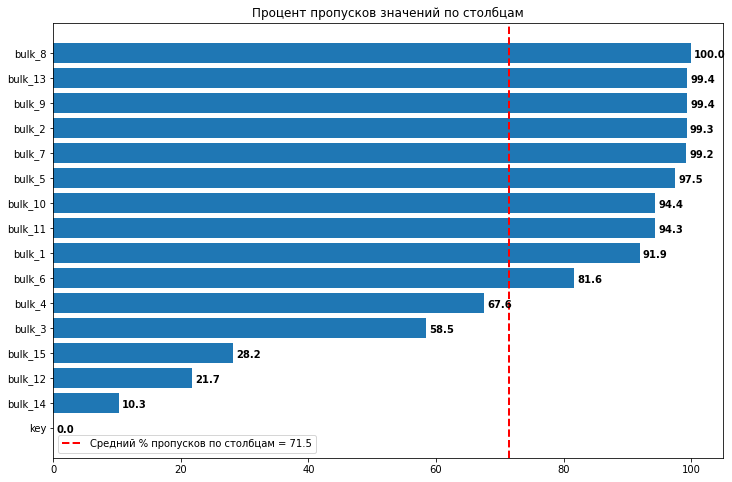

In [ ]:
percentage_of_nan(data_bulk_time)

#### data_bulk / сыпучие материалы (объём)

In [ ]:
try:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
except Exception:
    == вырезано цензурой ==
    data_bulk = pd.read_csv('/content/data_bulk.csv')
print()
display(data_bulk.sample(15,
                         random_state = random_state))

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1rmhDuQVoK3QKxrSmRF0SKEixCd3R1929
To: /content/data_bulk.csv
100% 115k/115k [00:00<00:00, 41.1MB/s]



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
322,345,NaN,NaN,NaN,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,257.0,NaN,130.0,203.0
1159,1207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,103.0,103.0
29,30,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.0,NaN,260.0,104.0
2716,2818,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,260.0,NaN,118.0,224.0
2155,2234,NaN,NaN,NaN,NaN,NaN,294.0,NaN,NaN,NaN,NaN,17.0,215.0,NaN,206.0,107.0
1653,1713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN
2631,2730,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.0,NaN,118.0,106.0
1206,1255,27.0,NaN,NaN,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,459.0,NaN,196.0,NaN
2722,2825,NaN,NaN,NaN,NaN,NaN,58.0,NaN,NaN,NaN,NaN,NaN,474.0,NaN,220.0,226.0
160,174,NaN,NaN,334.0,NaN,NaN,153.0,NaN,NaN,NaN,NaN,NaN,107.0,NaN,211.0,NaN


In [ ]:
column_rename(data_bulk)

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [ ]:
df_info(data_bulk)


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

Пропусков:
bulk_8     99.968041
bulk_13    99.424736
bulk_9     99.392777
bulk_2     99.296900
bulk_7     99.201023
bulk_5     97.539150
bulk_1

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Дубликатов = 0


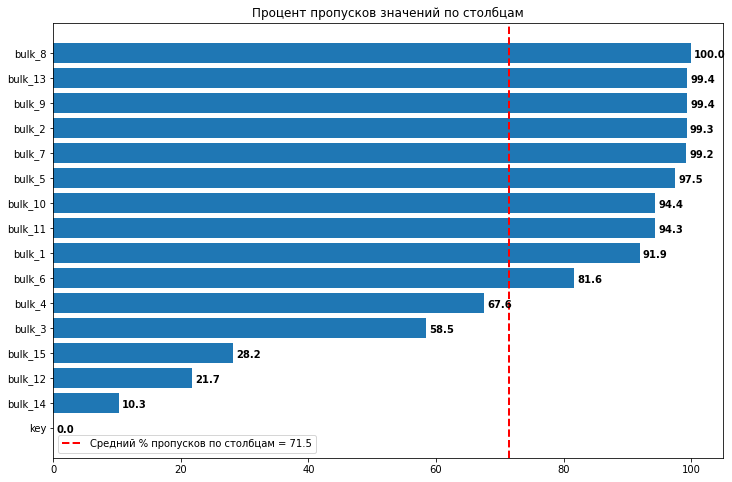

In [ ]:
percentage_of_nan(data_bulk)

#### data_gas / газ

In [ ]:
try:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
except Exception:
    == вырезано цензурой ==
    data_gas = pd.read_csv('/content/data_gas.csv')
print()
display(data_gas.sample(15,
                        random_state = random_state))

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1rnMtKcXUOEwClI32R5Voxwn_K74IdSvf
To: /content/data_gas.csv
100% 63.8k/63.8k [00:00<00:00, 40.7MB/s]



,key,Газ 1
2009,2012,7.435376
2024,2027,4.582993
691,694,12.264715
1673,1676,19.773123
865,868,6.461385
1153,1156,4.537058
149,150,4.713931
2914,2917,23.988264
2468,2471,10.824441
1540,1543,19.246283


In [ ]:
column_rename(data_gas)

Index(['key', 'газ_1'], dtype='object')

In [ ]:
df_info(data_gas)


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

Пропусков:
key      0.0
газ_1    0.0
dtype: float64

Описание:


,key,газ_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Дубликатов = 0


#### data_temp / температура

In [ ]:
try:
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
except Exception:
    == вырезано цензурой ==
    data_temp = pd.read_csv('/content/data_temp.csv')
print()
display(data_temp.sample(15,
                         random_state = random_state))

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1rtV07pIiiyK1qy2s11BZiQB16BHiCuva
To: /content/data_temp.csv
100% 486k/486k [00:00<00:00, 33.9MB/s]



,key,Время замера,Температура
14023,2847,2019-08-18 16:31:25,NaN
9873,2000,2019-07-19 19:37:17,1604.0
5332,1071,2019-06-11 15:30:48,1589.0
5877,1193,2019-06-15 13:45:57,1589.0
3636,721,2019-05-30 02:09:47,1570.0
3679,732,2019-05-30 09:57:52,1600.0
3405,668,2019-05-28 01:51:38,1585.0
14499,2940,2019-08-22 02:46:34,NaN
5256,1055,2019-06-10 23:51:25,1575.0
10351,2097,2019-07-23 04:10:24,1572.0


In [ ]:
column_rename(data_temp)

Index(['key', 'время_замера', 'температура'], dtype='object')

In [ ]:
df_info(data_temp)


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   время_замера  15907 non-null  object 
 2   температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

Пропусков:
температура     18.237254
key              0.000000
время_замера     0.000000
dtype: float64

Описание:


,key,температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000



Дубликатов = 0


Переведем дата в формат дат.

In [ ]:
data_temp['время_замера'] = pd.to_datetime(data_temp['время_замера'])
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   время_замера  15907 non-null  datetime64[ns]
 2   температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


#### data_wire_time / проволка (время)

In [ ]:
try:
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except Exception:
    == вырезано цензурой ==
    data_wire_time = pd.read_csv('/content/data_wire_time.csv')
print()
display(data_wire_time.sample(15,
                              random_state = random_state))

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1rlW1CE6ZAtqwjsFH0NyN0l2J24U2U4YP
To: /content/data_wire_time.csv
100% 125k/125k [00:00<00:00, 35.0MB/s]



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1751,1841,2019-07-07 19:52:21,2019-07-07 19:56:52,2019-07-07 20:16:17,NaN,NaN,NaN,NaN,NaN,NaN
2562,2696,2019-08-12 23:42:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1190,1258,2019-06-17 20:40:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2299,2423,2019-08-03 09:51:42,2019-08-03 09:53:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
817,871,2019-06-04 17:11:40,2019-06-04 17:13:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
470,502,2019-05-22 02:02:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1392,1464,2019-06-25 05:59:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1932,2027,2019-07-20 18:48:17,2019-07-20 18:38:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2190,2301,2019-07-30 02:57:09,2019-07-30 02:58:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1424,1496,2019-06-26 08:10:37,2019-06-26 08:12:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_rename(data_wire_time)

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [ ]:
df_info(data_wire_time)


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

Пропусков:
wire_5    99.967543
wire_7    99.642973
wire_4    99.545602
wire_8    99.383317
wire_9    99.058747
wire_3    97.955209
wire_6    97.630639
wire_2    64.978903
wire_1     0.843882
key        0.000000
dtype: float64

Описание:


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



Дубликатов = 0


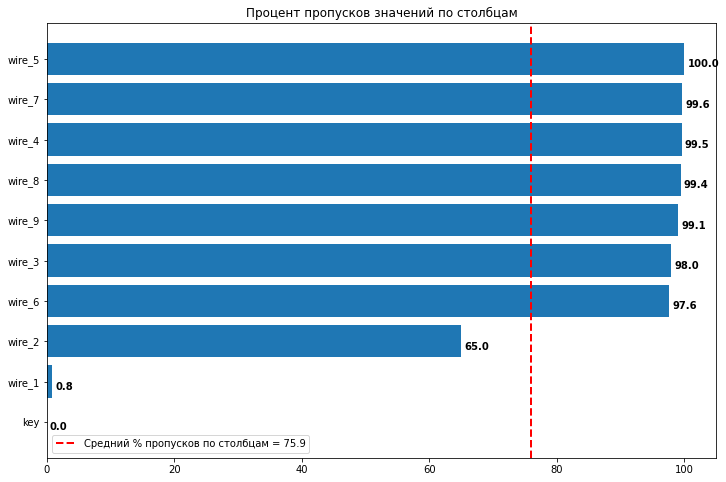

In [ ]:
percentage_of_nan(data_wire_time)

#### data_wire / проволка (объём)

In [ ]:
try:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
except Exception:
    == вырезано цензурой ==
    data_wire = pd.read_csv('/content/data_wire.csv')
print()
display(data_wire)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ruXRNMK6zqqmLYKzsUspBngF3qhok-Sn
To: /content/data_wire.csv
100% 91.5k/91.5k [00:00<00:00, 12.8MB/s]



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_rename(data_wire)

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [ ]:
df_info(data_wire)


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

Пропусков:
wire_5    99.967543
wire_7    99.642973
wire_4    99.545602
wire_8    99.383317
wire_9    99.058747
wire_3    97.955209
wire_6    97.630639
wire_2    64.978903
wire_1     0.843882
key        0.000000
dtype: float64

Описание:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Дубликатов = 0


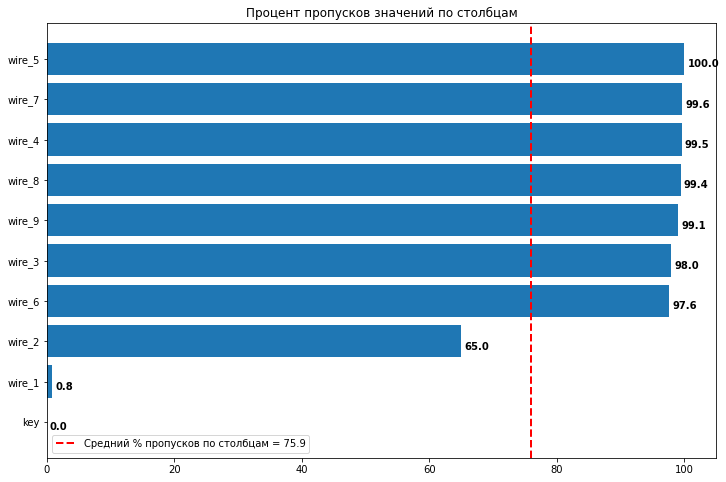

In [ ]:
percentage_of_nan(data_wire)

### Вывод

1.   data_arc
    *   `Начало нагрева дугой` и `Конец нагрева дугой` не в формате даты
2.   data_bulk_time
    *   Очень много пропусков. В среднем 71,5%, а `Bulk 8` все 100%.
    *   Все столбцы с датами в формате `object`.
3.   data_bulk
    *   Пропусков статистически как в предыдущей таблице. После объединения таблиц проверить на корреляцию.
4.   data_gas
    *   Все нормально
5.   data_temp
    *   Даты не даты.
    *   18% температур отсутствуют.
6.   data_wire_time
    *   Даты.
    *   Много пропусков. В среднем 75,9%.
7.   data_wire
    *   И снова с пропусками печаль.

Либо предоставлено избыточное количество столбцов, либо крайне халатное заполнение данных несколько осложнит исследования.

## Анализ данных

Позаимствуем некоторые данные с портала metallplace.ru:

*   Скорость прогревания металла примерно 5°С в минуту
*   Оптимальная температура, которую необходимо поддерживать в тигель-ковше, равняется примерно 1600 °С
*   Общее время, занимаемое процессом, составляет от 60 до 90 минут
*   От 10 до 30 минут, при этом, уходит на дуговой нагрев, происходящий циклически

Это может пригодиться для оценки предоставленных данных.

Сравним размеры таблиц.

In [ ]:
print('data_arc: ', data_arc.shape)
print('data_bulk_time: ', data_bulk_time.shape)
print('data_bulk: ', data_bulk.shape)
print('data_gas: ', data_gas.shape)
print('data_temp: ', data_temp.shape)
print('data_wire_time: ', data_wire_time.shape)
print('data_wire: ', data_wire.shape)

data_arc:  (14876, 5)
data_bulk_time:  (3129, 16)
data_bulk:  (3129, 16)
data_gas:  (3239, 2)
data_temp:  (15907, 3)
data_wire_time:  (3081, 10)
data_wire:  (3081, 10)


#### data_arc / электроды

##### key

'key в data_arc:'

array([   1,    2,    3, ..., 3239, 3240, 3241])

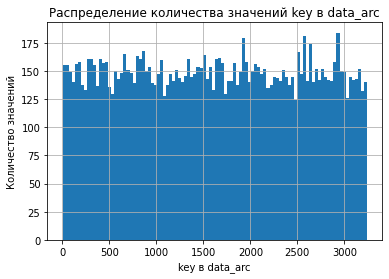

<Figure size 432x216 with 0 Axes>

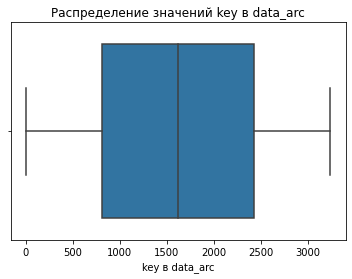

<Figure size 432x216 with 0 Axes>

In [ ]:
display('key в data_arc:', data_arc['key'].sort_values().unique())
print()
display(data_arc['key'].hist(bins=100))
plt.title("Распределение количества значений key в data_arc")
plt.xlabel("key в data_arc")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_arc,
                         x = 'key',
                         orient = 'h'))
plt.title("Распределение значений key в data_arc")
plt.xlabel("key в data_arc")
plt.figure(figsize=(6, 3))
plt.show()

##### Начало нагрева дугой

'Начало нагрева дугой в data_arc:'

array(['2019-05-03T11:02:14.000000000', '2019-05-03T11:07:28.000000000',
       '2019-05-03T11:11:44.000000000', ...,
       '2019-09-01T04:16:41.000000000', '2019-09-01T04:31:51.000000000',
       '2019-09-01T04:34:47.000000000'], dtype='datetime64[ns]')

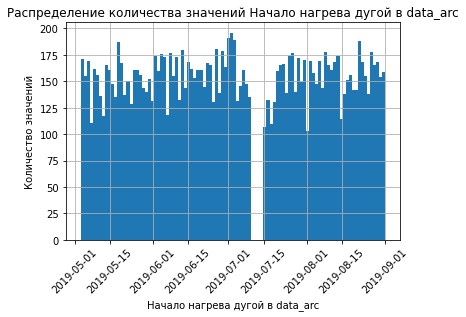

In [ ]:
display('Начало нагрева дугой в data_arc:', data_arc['начало_нагрева_дугой'].sort_values().unique())
print()
display(data_arc['начало_нагрева_дугой'].hist(bins=100))
plt.title("Распределение количества значений Начало нагрева дугой в data_arc")
plt.xlabel("Начало нагрева дугой в data_arc")
plt.xticks(rotation = 45)
plt.ylabel("Количество значений")
plt.show()

##### Конец нагрева дугой

'Конец нагрева дугой в data_arc:'

array(['2019-05-03T11:06:02.000000000', '2019-05-03T11:10:33.000000000',
       '2019-05-03T11:14:36.000000000', ...,
       '2019-09-01T04:19:45.000000000', '2019-09-01T04:32:48.000000000',
       '2019-09-01T04:36:08.000000000'], dtype='datetime64[ns]')

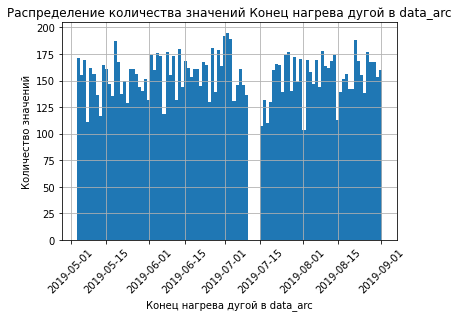

In [ ]:
display('Конец нагрева дугой в data_arc:', data_arc['конец_нагрева_дугой'].sort_values().unique())
print()
display(data_arc['конец_нагрева_дугой'].hist(bins=100))
plt.title("Распределение количества значений Конец нагрева дугой в data_arc")
plt.xlabel("Конец нагрева дугой в data_arc")
plt.xticks(rotation = 45)
plt.ylabel("Количество значений")
plt.show()

##### Активная мощность


Количество значений `Активная мощность` = 14876 шт.



'Активная мощность в data_arc:'

array([0.03000194, 0.03018816, 0.0301905 , ..., 3.15076178, 3.15627646,
       3.73159611])

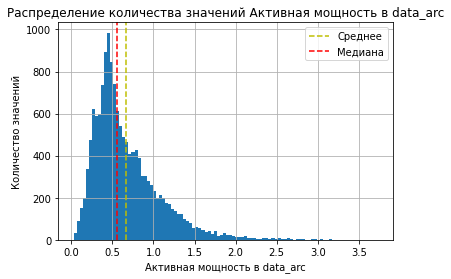

<Figure size 432x216 with 0 Axes>

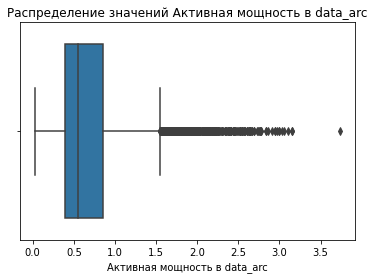

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Активная мощность` =', data_arc['активная_мощность'].count(), 'шт.\n')
display('Активная мощность в data_arc:', data_arc['активная_мощность'].sort_values().unique())
print()
display(data_arc['активная_мощность'].hist(bins=100))
plt.axvline(data_arc['активная_мощность'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_arc["активная_мощность"].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Активная мощность в data_arc")
plt.xlabel("Активная мощность в data_arc")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_arc,
                         x = 'активная_мощность',
                         orient = 'h'))
plt.title("Распределение значений Активная мощность в data_arc")
plt.xlabel("Активная мощность в data_arc")
plt.figure(figsize=(6, 3))
plt.show()

##### Реактивная мощность


Количество значений `Реактивная мощность` = 14876 шт.



'Реактивная мощность в data_arc:'

array([-7.15504924e+02,  2.08063126e-02,  2.11541653e-02, ...,
        2.45995915e+00,  2.50420606e+00,  2.67638755e+00])

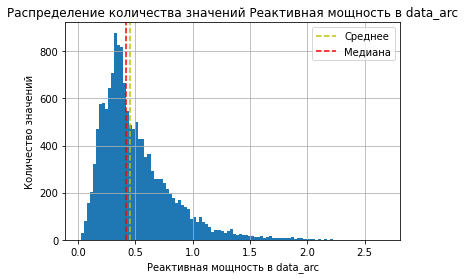

<Figure size 432x216 with 0 Axes>

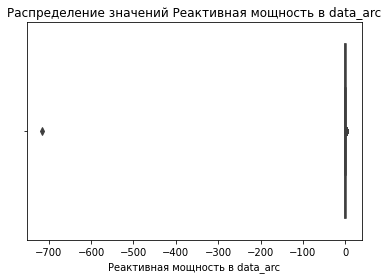

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Реактивная мощность` =', data_arc['реактивная_мощность'].count(), 'шт.\n')
display('Реактивная мощность в data_arc:', data_arc['реактивная_мощность'].sort_values().unique())
print()
display(data_arc['реактивная_мощность'].hist(bins=100,
                                             range = (2.08063126e-02, 2.67638755e+00)))
plt.axvline(data_arc['реактивная_мощность'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_arc['реактивная_мощность'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Реактивная мощность в data_arc")
plt.xlabel("Реактивная мощность в data_arc")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_arc,
                         x = 'реактивная_мощность',
                         orient = 'h'))
plt.title("Распределение значений Реактивная мощность в data_arc")
plt.xlabel("Реактивная мощность в data_arc")
plt.figure(figsize=(6, 3))
plt.show()

Удалим этот явный выброс.

In [ ]:
data_arc['реактивная_мощность'].sort_values()

9780    -715.504924
5596       0.020806
2419       0.021154
4914       0.022485
4633       0.022983
            ...    
13760      2.335088
12424      2.397032
9361       2.459959
9226       2.504206
7799       2.676388
Name: реактивная_мощность, Length: 14876, dtype: float64

In [ ]:
data_arc = data_arc.drop(9780)

In [ ]:
data_arc['реактивная_мощность'].sort_values()

5596     0.020806
2419     0.021154
4914     0.022485
4633     0.022983
676      0.023228
           ...   
13760    2.335088
12424    2.397032
9361     2.459959
9226     2.504206
7799     2.676388
Name: реактивная_мощность, Length: 14875, dtype: float64

#### data_bulk_time / сыпучие материалы (время)

In [ ]:
column_values_3(data_bulk_time)


Значения столбца key :
[   1    2    3 ... 3239 3240 3241]

Значения столбца bulk_1 :
['2019-05-03 17:50:19' '2019-05-05 10:09:13' '2019-05-05 11:01:42'
 '2019-05-05 11:59:23' '2019-05-05 13:13:45' '2019-05-05 14:17:04'
 '2019-05-05 15:03:54' '2019-05-05 16:00:33' '2019-05-05 20:49:32'
 '2019-05-07 11:24:41' '2019-05-07 15:37:52' '2019-05-07 16:15:34'
 '2019-05-07 17:35:13' '2019-05-08 01:00:11' '2019-05-08 05:26:23'
 '2019-05-08 10:05:03' '2019-05-08 10:39:56' '2019-05-08 11:33:17'
 '2019-05-08 15:14:16' '2019-05-09 04:35:17' '2019-05-10 16:46:26'
 '2019-05-10 17:16:52' '2019-05-10 18:41:05' '2019-05-10 20:05:32'
 '2019-05-11 10:46:17' '2019-05-11 12:15:55' '2019-05-11 17:50:54'
 '2019-05-12 15:36:08' '2019-05-12 16:43:26' '2019-05-12 21:33:11'
 '2019-05-13 13:14:48' '2019-05-13 14:36:57' '2019-05-14 12:01:34'
 '2019-05-14 14:09:52' '2019-05-14 16:24:02' '2019-05-14 21:58:07'
 '2019-05-15 09:27:40' '2019-05-15 15:05:04' '2019-05-15 21:42:31'
 '2019-05-15 23:52:57' '2019-05-16 01:41:0

##### key

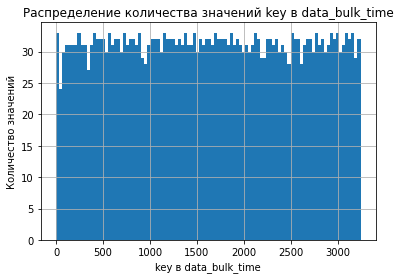

<Figure size 432x216 with 0 Axes>

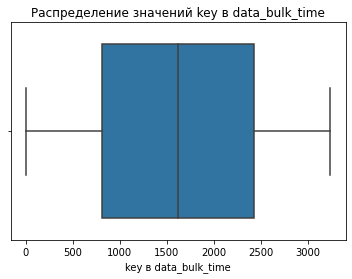

<Figure size 432x216 with 0 Axes>

In [ ]:
display(data_bulk_time['key'].hist(bins=100))
plt.title("Распределение количества значений key в data_bulk_time")
plt.xlabel("key в data_bulk_time")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk_time,
                         x = 'key',
                         orient = 'h'))
plt.title("Распределение значений key в data_bulk_time")
plt.xlabel("key в data_bulk_time")
plt.figure(figsize=(6, 3))
plt.show()

#### data_bulk / сыпучие материалы (объём)

In [ ]:
column_values_3(data_bulk)


Значения столбца key :
[   1    2    3 ... 3239 3240 3241]

Значения столбца bulk_1 :
[ 10.  16.  19.  21.  22.  24.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  36.  37.  38.  39.  41.  43.  44.  46.  47.  48.  50.  51.  52.
  54.  58.  60.  62.  63.  65.  67.  69.  73.  74.  75.  78.  83.  90.
  92.  94. 104. 118. 185.  nan]

Значения столбца bulk_2 :
[228. 232. 233. 236. 242. 246. 247. 248. 249. 254. 257. 258. 270. 282.
 325.  nan]

Значения столбца bulk_3 :
[  6.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  34.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 116. 117. 118. 119. 120. 121. 122

##### key

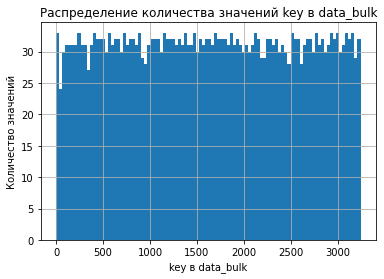

<Figure size 432x216 with 0 Axes>

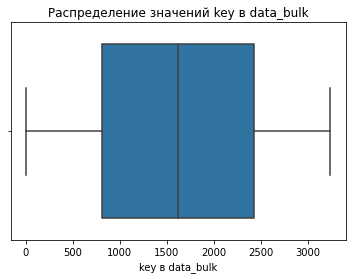

<Figure size 432x216 with 0 Axes>

In [ ]:
display(data_bulk['key'].hist(bins=100))
plt.title("Распределение количества значений key в data_bulk")
plt.xlabel("key в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'key',
                         orient = 'h'))
plt.title("Распределение значений key в data_bulk")
plt.xlabel("key в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

##### Bulk 1


Количество значений `Bulk 1` = 252 шт.



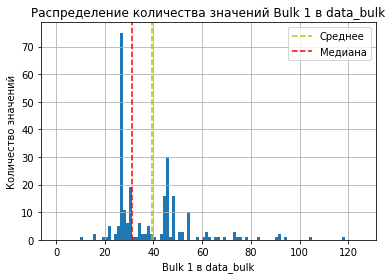

<Figure size 432x216 with 0 Axes>

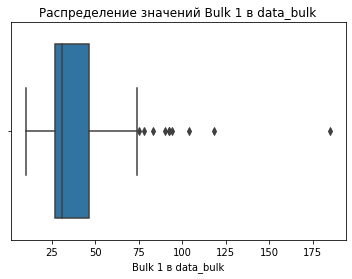

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 1` =', data_bulk['bulk_1'].count(), 'шт.\n')
display(data_bulk['bulk_1'].hist(bins=100,
                                 range = (0, 125)))
plt.axvline(data_bulk['bulk_1'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_bulk["bulk_1"].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Bulk 1 в data_bulk")
plt.xlabel("Bulk 1 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_1',
                         orient = 'h'))
plt.title("Распределение значений Bulk 1 в data_bulk")
plt.xlabel("Bulk 1 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

##### Bulk 2


Количество значений `Bulk 2` = 22 шт.



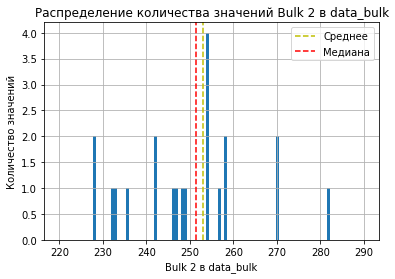

<Figure size 432x216 with 0 Axes>

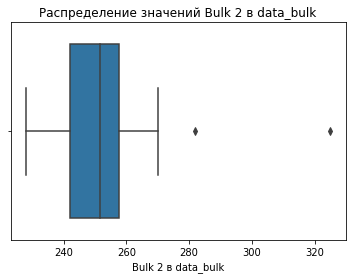

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 2` =', data_bulk['bulk_2'].count(), 'шт.\n')
display(data_bulk['bulk_2'].hist(bins=100,
                                 range = (220, 290)))
plt.axvline(data_bulk['bulk_2'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_bulk['bulk_2'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Bulk 2 в data_bulk")
plt.xlabel("Bulk 2 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_2',
                         orient = 'h'))
plt.title("Распределение значений Bulk 2 в data_bulk")
plt.xlabel("Bulk 2 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

##### Bulk 3


Количество значений `Bulk 3` = 1298 шт.



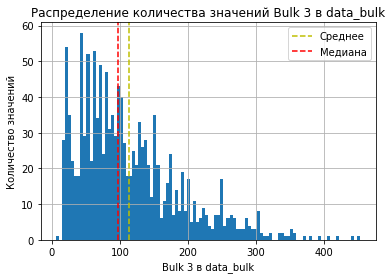

<Figure size 432x216 with 0 Axes>

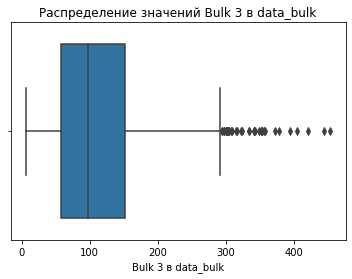

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 3` =', data_bulk['bulk_3'].count(), 'шт.\n')
display(data_bulk['bulk_3'].hist(bins=100))
plt.axvline(data_bulk['bulk_3'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_bulk['bulk_3'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Bulk 3 в data_bulk")
plt.xlabel("Bulk 3 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_3',
                         orient = 'h'))
plt.title("Распределение значений Bulk 3 в data_bulk")
plt.xlabel("Bulk 3 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

##### Bulk 4


Количество значений `Bulk 4` = 1014 шт.



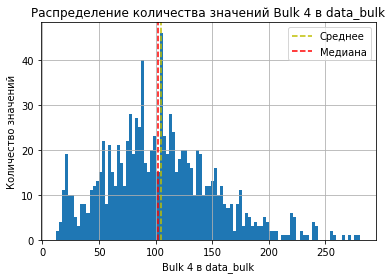

<Figure size 432x216 with 0 Axes>

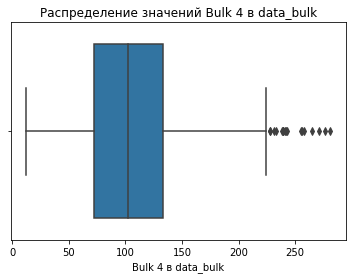

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 4` =', data_bulk['bulk_4'].count(), 'шт.\n')
display(data_bulk['bulk_4'].hist(bins=100))
plt.axvline(data_bulk['bulk_4'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_bulk['bulk_4'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Bulk 4 в data_bulk")
plt.xlabel("Bulk 4 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_4',
                         orient = 'h'))
plt.title("Распределение значений Bulk 4 в data_bulk")
plt.xlabel("Bulk 4 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

##### Bulk 5


Количество значений `Bulk 5` = 77 шт.



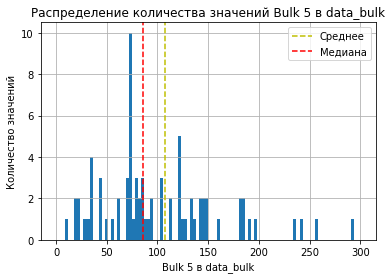

<Figure size 432x216 with 0 Axes>

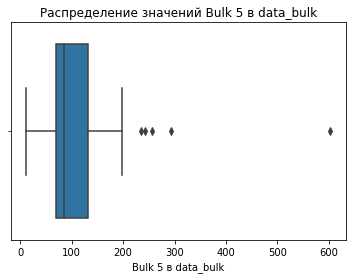

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 5` =', data_bulk['bulk_5'].count(), 'шт.\n')
display(data_bulk['bulk_5'].hist(bins=100,
                                 range = (0, 300)))
plt.axvline(data_bulk['bulk_5'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_bulk['bulk_5'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Bulk 5 в data_bulk")
plt.xlabel("Bulk 5 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_5',
                         orient = 'h'))
plt.title("Распределение значений Bulk 5 в data_bulk")
plt.xlabel("Bulk 5 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

##### Bulk 6


Количество значений `Bulk 6` = 576 шт.



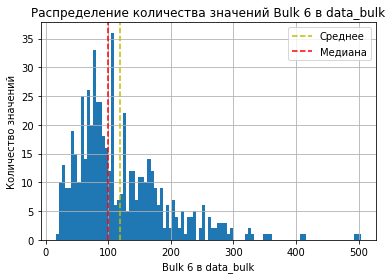

<Figure size 432x216 with 0 Axes>

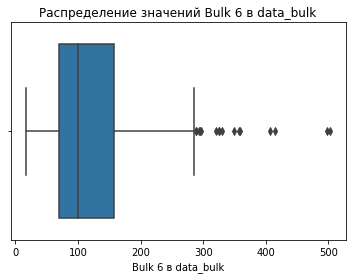

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 6` =', data_bulk['bulk_6'].count(), 'шт.\n')
display(data_bulk['bulk_6'].hist(bins=100))
plt.axvline(data_bulk['bulk_6'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_bulk['bulk_6'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Bulk 6 в data_bulk")
plt.xlabel("Bulk 6 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_6',
                         orient = 'h'))
plt.title("Распределение значений Bulk 6 в data_bulk")
plt.xlabel("Bulk 6 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

##### Bulk 7


Количество значений `Bulk 7` = 25 шт.



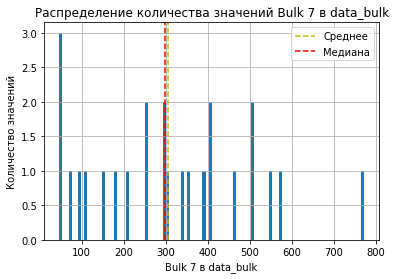

<Figure size 432x216 with 0 Axes>

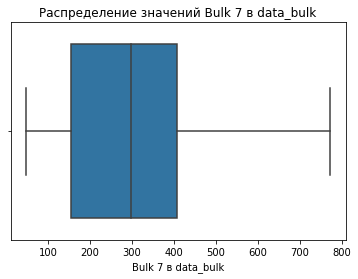

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 7` =', data_bulk['bulk_7'].count(), 'шт.\n')
display(data_bulk['bulk_7'].hist(bins=100))
plt.axvline(data_bulk['bulk_7'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_bulk['bulk_7'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Bulk 7 в data_bulk")
plt.xlabel("Bulk 7 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_7',
                         orient = 'h'))
plt.title("Распределение значений Bulk 7 в data_bulk")
plt.xlabel("Bulk 7 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

##### Bulk 8


Количество значений `Bulk 8` = 1 шт.



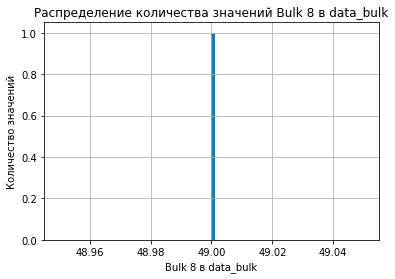

<Figure size 432x216 with 0 Axes>

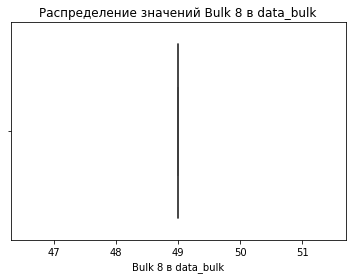

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 8` =', data_bulk['bulk_8'].count(), 'шт.\n')
display(data_bulk['bulk_8'].hist(bins=100,
                                 range = (48.95, 49.05)))
plt.title("Распределение количества значений Bulk 8 в data_bulk")
plt.xlabel("Bulk 8 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_8',
                         orient = 'h'))
plt.title("Распределение значений Bulk 8 в data_bulk")
plt.xlabel("Bulk 8 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

##### Bulk 9


Количество значений `Bulk 9` = 19 шт.



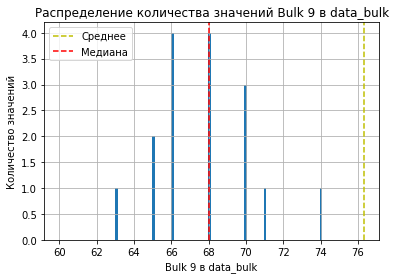

<Figure size 432x216 with 0 Axes>

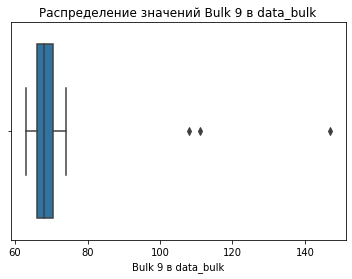

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 9` =', data_bulk['bulk_9'].count(), 'шт.\n')
display(data_bulk['bulk_9'].hist(bins=100,
                                 range = (60, 75)))
plt.axvline(data_bulk['bulk_9'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_bulk['bulk_9'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Bulk 9 в data_bulk")
plt.xlabel("Bulk 9 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_9',
                         orient = 'h'))
plt.title("Распределение значений Bulk 9 в data_bulk")
plt.xlabel("Bulk 9 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

Проверим гипотезу: крайнеправый выброс по всем Bulk принадлежит одной партии.

In [ ]:
print(data_bulk['bulk_1'].sort_values(ascending=False).head(3))
print(data_bulk['bulk_2'].sort_values(ascending=False).head(3))
print(data_bulk['bulk_5'].sort_values(ascending=False).head(3))
print(data_bulk['bulk_6'].sort_values(ascending=False).head(3))
print(data_bulk['bulk_9'].sort_values(ascending=False).head(3))

303     185.0
2423    118.0
2840    104.0
Name: bulk_1, dtype: float64
104     325.0
2035    282.0
2478    270.0
Name: bulk_2, dtype: float64
1747    603.0
1991    293.0
1995    256.0
Name: bulk_5, dtype: float64
1219    503.0
2535    498.0
2533    414.0
Name: bulk_6, dtype: float64
1725    147.0
1910    111.0
1911    108.0
Name: bulk_9, dtype: float64


Не подтвердилось.

##### Bulk 10


Количество значений `Bulk 10` = 176 шт.



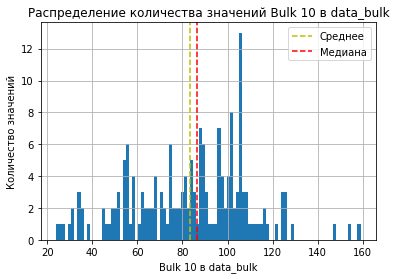

<Figure size 432x216 with 0 Axes>

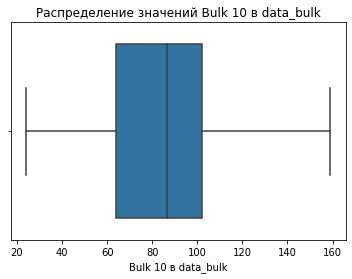

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 10` =', data_bulk['bulk_10'].count(), 'шт.\n')
display(data_bulk['bulk_10'].hist(bins=100))
plt.axvline(data_bulk['bulk_10'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_bulk['bulk_10'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Bulk 10 в data_bulk")
plt.xlabel("Bulk 10 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_10',
                         orient = 'h'))
plt.title("Распределение значений Bulk 10 в data_bulk")
plt.xlabel("Bulk 10 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

##### Bulk 11


Количество значений `Bulk 11` = 177 шт.



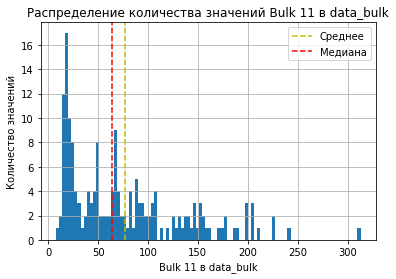

<Figure size 432x216 with 0 Axes>

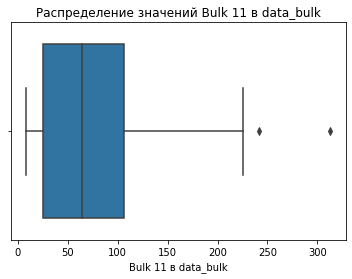

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 11` =', data_bulk['bulk_11'].count(), 'шт.\n')
display(data_bulk['bulk_11'].hist(bins=100))
plt.axvline(data_bulk['bulk_11'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_bulk['bulk_11'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Bulk 11 в data_bulk")
plt.xlabel("Bulk 11 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_11',
                         orient = 'h'))
plt.title("Распределение значений Bulk 11 в data_bulk")
plt.xlabel("Bulk 11 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

##### Bulk 12


Количество значений `Bulk 12` = 2450 шт.



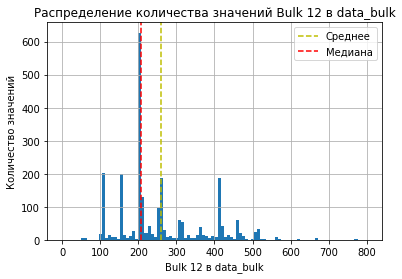

<Figure size 432x216 with 0 Axes>

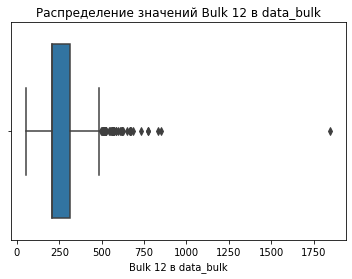

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 12` =', data_bulk['bulk_12'].count(), 'шт.\n')
display(data_bulk['bulk_12'].hist(bins=100,
                                 range = (0, 800)))
plt.axvline(data_bulk['bulk_12'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_bulk['bulk_12'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Bulk 12 в data_bulk")
plt.xlabel("Bulk 12 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_12',
                         orient = 'h'))
plt.title("Распределение значений Bulk 12 в data_bulk")
plt.xlabel("Bulk 12 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

##### Bulk 13


Количество значений `Bulk 13` = 18 шт.



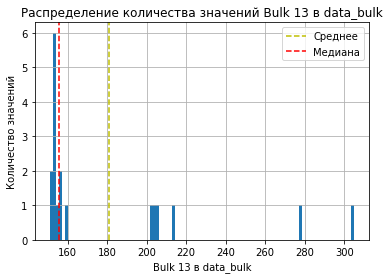

<Figure size 432x216 with 0 Axes>

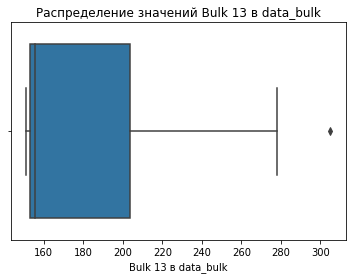

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 13` =', data_bulk['bulk_13'].count(), 'шт.\n')
display(data_bulk['bulk_13'].hist(bins=100))
plt.axvline(data_bulk['bulk_13'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_bulk['bulk_13'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Bulk 13 в data_bulk")
plt.xlabel("Bulk 13 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_13',
                         orient = 'h'))
plt.title("Распределение значений Bulk 13 в data_bulk")
plt.xlabel("Bulk 13 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

##### Bulk 14


Количество значений `Bulk 14` = 2806 шт.



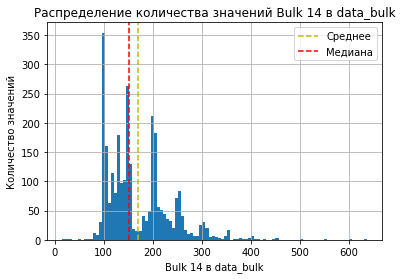

<Figure size 432x216 with 0 Axes>

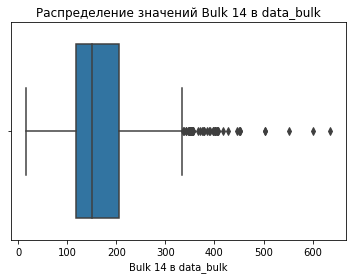

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 14` =', data_bulk['bulk_14'].count(), 'шт.\n')
display(data_bulk['bulk_14'].hist(bins=100))
plt.axvline(data_bulk['bulk_14'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_bulk['bulk_14'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Bulk 14 в data_bulk")
plt.xlabel("Bulk 14 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_14',
                         orient = 'h'))
plt.title("Распределение значений Bulk 14 в data_bulk")
plt.xlabel("Bulk 14 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

##### Bulk 15


Количество значений `Bulk 15` = 2248 шт.



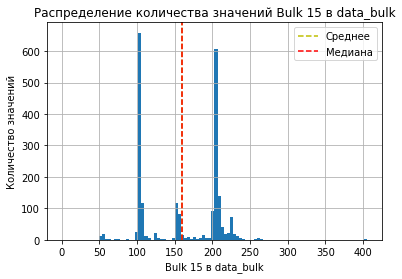

<Figure size 432x216 with 0 Axes>

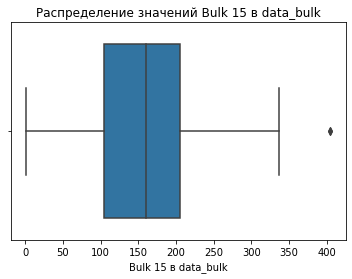

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Bulk 15` =', data_bulk['bulk_15'].count(), 'шт.\n')
display(data_bulk['bulk_15'].hist(bins=100))
plt.axvline(data_bulk['bulk_15'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_bulk['bulk_15'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Bulk 15 в data_bulk")
plt.xlabel("Bulk 15 в data_bulk")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_bulk,
                         x = 'bulk_15',
                         orient = 'h'))
plt.title("Распределение значений Bulk 15 в data_bulk")
plt.xlabel("Bulk 15 в data_bulk")
plt.figure(figsize=(6, 3))
plt.show()

#### data_gas / газ

In [ ]:
column_values_3(data_gas)


Значения столбца key :
[   1    2    3 ... 3239 3240 3241]

Значения столбца газ_1 :
[8.39852910e-03 1.66956024e-02 2.63028954e-01 ... 5.21423726e+01
 6.09356892e+01 7.79950397e+01]


##### key

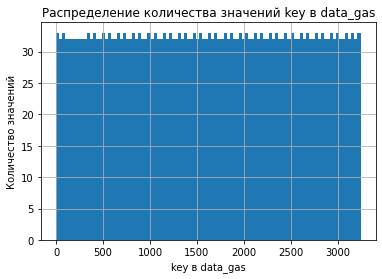

<Figure size 432x216 with 0 Axes>

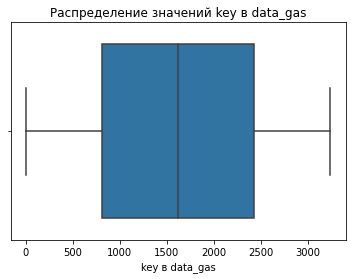

<Figure size 432x216 with 0 Axes>

In [ ]:
display(data_gas['key'].hist(bins=100))
plt.title("Распределение количества значений key в data_gas")
plt.xlabel("key в data_gas")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_gas,
                         x = 'key',
                         orient = 'h'))
plt.title("Распределение значений key в data_gas")
plt.xlabel("key в data_gas")
plt.figure(figsize=(6, 3))
plt.show()

##### Газ 1


Количество значений `Газ 1` = 3239 шт.



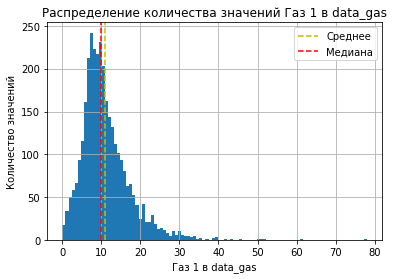

<Figure size 432x216 with 0 Axes>

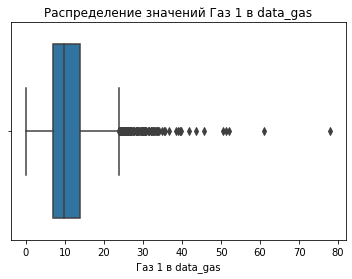

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Газ 1` =', data_gas['газ_1'].count(), 'шт.\n')
display(data_gas['газ_1'].hist(bins=100))
plt.axvline(data_gas['газ_1'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_gas['газ_1'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Газ 1 в data_gas")
plt.xlabel("Газ 1 в data_gas")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_gas,
                         x = 'газ_1',
                         orient = 'h'))
plt.title("Распределение значений Газ 1 в data_gas")
plt.xlabel("Газ 1 в data_gas")
plt.figure(figsize=(6, 3))
plt.show()

#### data_temp / температура

In [ ]:
column_values_3(data_temp)


Значения столбца key :
[   1    2    3 ... 3239 3240 3241]

Значения столбца время_замера :
['2019-05-03T11:16:18.000000000' '2019-05-03T11:25:53.000000000'
 '2019-05-03T11:29:11.000000000' ... '2019-09-01T04:22:39.000000000'
 '2019-09-01T04:33:42.000000000' '2019-09-01T04:38:08.000000000']

Значения столбца температура :
[1191. 1204. 1208. 1218. 1227. 1383. 1519. 1520. 1525. 1526. 1527. 1528.
 1529. 1530. 1531. 1532. 1533. 1534. 1535. 1536. 1537. 1538. 1539. 1540.
 1541. 1542. 1543. 1544. 1545. 1546. 1547. 1548. 1549. 1550. 1551. 1552.
 1553. 1554. 1555. 1556. 1557. 1558. 1559. 1560. 1561. 1562. 1563. 1564.
 1565. 1566. 1567. 1568. 1569. 1570. 1571. 1572. 1573. 1574. 1575. 1576.
 1577. 1578. 1579. 1580. 1581. 1582. 1583. 1584. 1585. 1586. 1587. 1588.
 1589. 1590. 1591. 1592. 1593. 1594. 1595. 1596. 1597. 1598. 1599. 1600.
 1601. 1602. 1603. 1604. 1605. 1606. 1607. 1608. 1609. 1610. 1611. 1612.
 1613. 1614. 1615. 1616. 1617. 1618. 1619. 1620. 1621. 1622. 1623. 1624.
 1625. 1626. 1627.

##### key

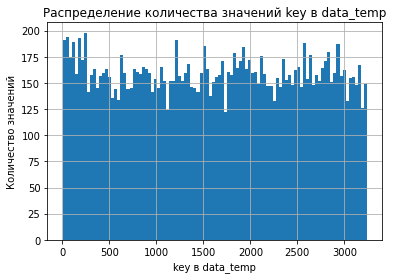

<Figure size 432x216 with 0 Axes>

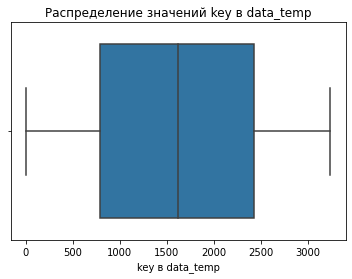

<Figure size 432x216 with 0 Axes>

In [ ]:
display(data_temp['key'].hist(bins=100))
plt.title("Распределение количества значений key в data_temp")
plt.xlabel("key в data_temp")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_temp,
                         x = 'key',
                         orient = 'h'))
plt.title("Распределение значений key в data_temp")
plt.xlabel("key в data_temp")
plt.figure(figsize=(6, 3))
plt.show()

##### Температура


Количество значений `Температура` = 13006 шт.



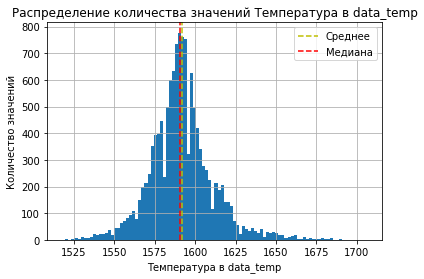

<Figure size 432x216 with 0 Axes>

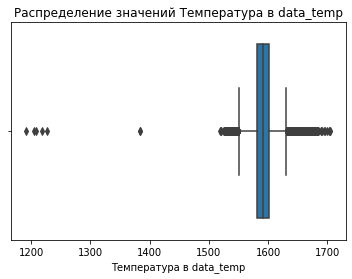

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Температура` =', data_temp['температура'].count(), 'шт.\n')
display(data_temp['температура'].hist(bins=100,
                                      range = (1518, 1706)))
plt.axvline(data_temp['температура'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_temp['температура'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Температура в data_temp")
plt.xlabel("Температура в data_temp")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_temp,
                         x = 'температура',
                         orient = 'h'))
plt.title("Распределение значений Температура в data_temp")
plt.xlabel("Температура в data_temp")
plt.figure(figsize=(6, 3))
plt.show()

Температура должна быть порядка 1600 градусов. Все что меньше 1500 отсеим как выбросы.

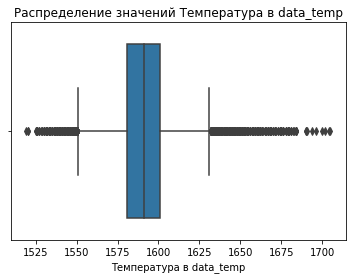

In [ ]:
data_temp = data_temp.loc[data_temp['температура'] >= 1500]
display(ax = sns.boxplot(data = data_temp,
                         x = 'температура',
                         orient = 'h'))
plt.title("Распределение значений Температура в data_temp")
plt.xlabel("Температура в data_temp")
plt.show()

#### data_wire_time / проволка (время)

In [ ]:
column_values_3(data_wire_time)


Значения столбца key :
[   1    2    3 ... 3239 3240 3241]

Значения столбца wire_1 :
['2019-05-03 11:11:41' '2019-05-03 11:46:10' '2019-05-03 12:13:47' ...
 '2019-09-01 03:12:02' '2019-09-01 04:16:01' nan]

Значения столбца wire_2 :
['2019-05-03 13:32:06' '2019-05-03 13:59:54' '2019-05-03 15:58:12' ...
 '2019-08-31 13:14:22' '2019-08-31 18:50:15' nan]

Значения столбца wire_3 :
['2019-05-04 04:47:53' '2019-05-04 05:40:08' '2019-05-07 08:50:29'
 '2019-05-07 10:17:14' '2019-05-07 15:50:31' '2019-05-07 16:34:12'
 '2019-05-07 17:43:23' '2019-05-07 21:58:49' '2019-05-07 22:40:07'
 '2019-05-07 23:27:46' '2019-05-18 13:04:48' '2019-05-18 13:41:36'
 '2019-05-18 20:52:18' '2019-05-18 21:49:12' '2019-06-02 20:37:44'
 '2019-06-08 16:23:31' '2019-06-10 13:19:54' '2019-06-10 14:05:33'
 '2019-06-10 14:25:42' '2019-06-12 01:29:02' '2019-06-12 20:11:25'
 '2019-06-12 21:27:01' '2019-07-07 18:33:17' '2019-07-07 19:25:35'
 '2019-07-07 20:16:17' '2019-07-08 17:20:59' '2019-07-08 18:12:51'
 '2019-07-15 2

##### key

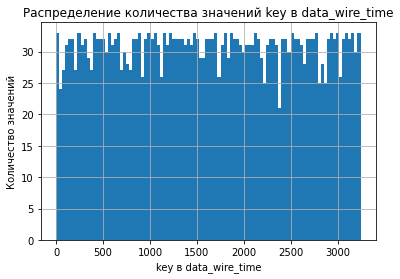

<Figure size 432x216 with 0 Axes>

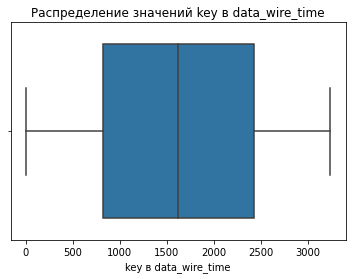

<Figure size 432x216 with 0 Axes>

In [ ]:
display(data_wire_time['key'].hist(bins=100))
plt.title("Распределение количества значений key в data_wire_time")
plt.xlabel("key в data_wire_time")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_wire_time,
                         x = 'key',
                         orient = 'h'))
plt.title("Распределение значений key в data_wire_time")
plt.xlabel("key в data_wire_time")
plt.figure(figsize=(6, 3))
plt.show()

#### data_wire / проволка (объём)

In [ ]:
column_values_3(data_wire)


Значения столбца key :
[   1    2    3 ... 3239 3240 3241]

Значения столбца wire_1 :
[  1.9188     2.09664    3.10128  ... 280.987214 330.314424        nan]

Значения столбца wire_2 :
[3.01600000e-02 6.03200000e-02 9.04800000e-02 9.04800000e-02
 1.74720000e-01 5.82400000e-01 1.17624000e+00 1.60160000e+00
 2.74456000e+00 3.98112000e+00 4.10176000e+00 4.13192000e+00
 5.12720000e+00 7.72096000e+00 8.08288000e+00 8.11304000e+00
 8.17336000e+00 8.83688000e+00 9.01784000e+00 9.04800000e+00
 9.07816000e+00 9.08544100e+00 9.10832000e+00 9.11456000e+00
 9.13848000e+00 9.14368100e+00 9.16864000e+00 9.19880000e+00
 9.22896000e+00 9.31944000e+00 9.68136000e+00 1.00432800e+01
 1.00734400e+01 1.01036000e+01 1.01337590e+01 1.01337600e+01
 1.01639190e+01 1.01940790e+01 1.02242400e+01 1.10385600e+01
 1.10687200e+01 1.10988800e+01 1.11238400e+01 1.11290400e+01
 1.11592000e+01 1.11893600e+01 1.12195200e+01 1.20338400e+01
 1.20848000e+01 1.20941600e+01 1.21243200e+01 1.21430400e+01
 1.21544800e+01 1.217

##### key

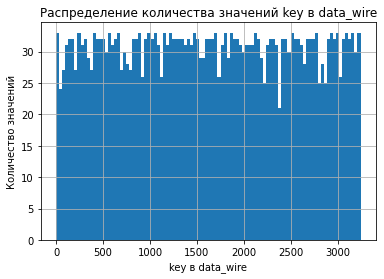

<Figure size 432x216 with 0 Axes>

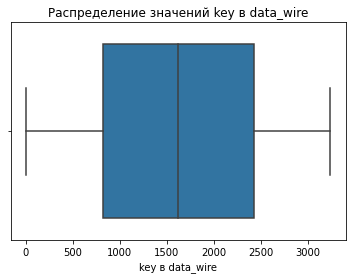

<Figure size 432x216 with 0 Axes>

In [ ]:
display(data_wire['key'].hist(bins=100))
plt.title("Распределение количества значений key в data_wire")
plt.xlabel("key в data_wire")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_wire,
                         x = 'key',
                         orient = 'h'))
plt.title("Распределение значений key в data_wire")
plt.xlabel("key в data_wire")
plt.figure(figsize=(6, 3))
plt.show()

##### Wire 1


Количество значений `Wire 1` = 3055 шт.



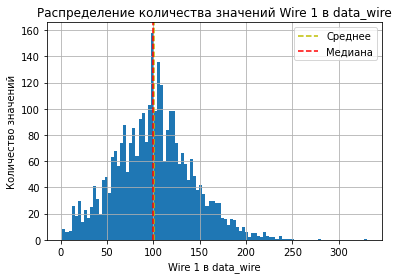

<Figure size 432x216 with 0 Axes>

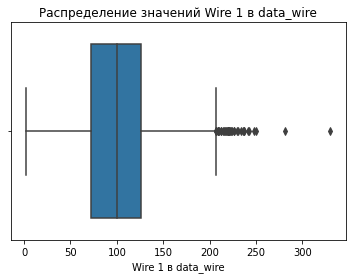

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Wire 1` =', data_wire['wire_1'].count(), 'шт.\n')
display(data_wire['wire_1'].hist(bins=100))
plt.axvline(data_wire['wire_1'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_wire['wire_1'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Wire 1 в data_wire")
plt.xlabel("Wire 1 в data_wire")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_wire,
                         x = 'wire_1',
                         orient = 'h'))
plt.title("Распределение значений Wire 1 в data_wire")
plt.xlabel("Wire 1 в data_wire")
plt.figure(figsize=(6, 3))
plt.show()

##### Wire 2


Количество значений `Wire 2` = 1079 шт.



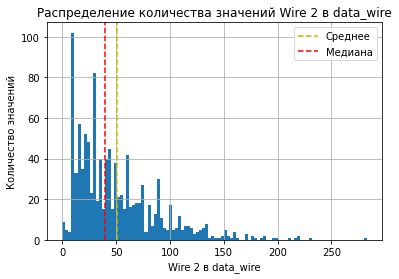

<Figure size 432x216 with 0 Axes>

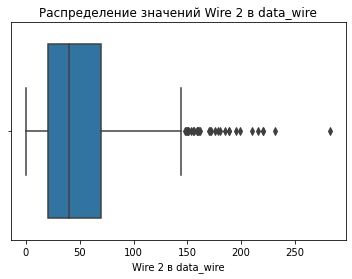

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Wire 2` =', data_wire['wire_2'].count(), 'шт.\n')
display(data_wire['wire_2'].hist(bins=100))
plt.axvline(data_wire['wire_2'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_wire['wire_2'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Wire 2 в data_wire")
plt.xlabel("Wire 2 в data_wire")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_wire,
                         x = 'wire_2',
                         orient = 'h'))
plt.title("Распределение значений Wire 2 в data_wire")
plt.xlabel("Wire 2 в data_wire")
plt.figure(figsize=(6, 3))
plt.show()

##### Wire 3


Количество значений `Wire 3` = 63 шт.



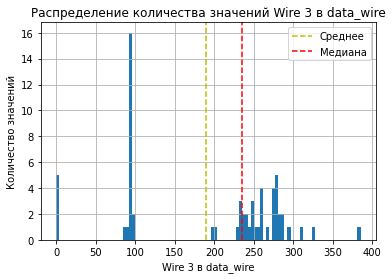

<Figure size 432x216 with 0 Axes>

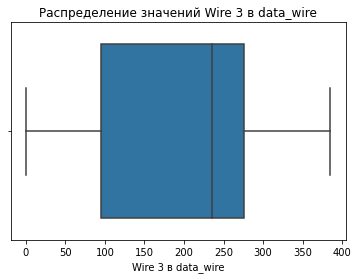

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Wire 3` =', data_wire['wire_3'].count(), 'шт.\n')
display(data_wire['wire_3'].hist(bins=100))
plt.axvline(data_wire['wire_3'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_wire['wire_3'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Wire 3 в data_wire")
plt.xlabel("Wire 3 в data_wire")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_wire,
                         x = 'wire_3',
                         orient = 'h'))
plt.title("Распределение значений Wire 3 в data_wire")
plt.xlabel("Wire 3 в data_wire")
plt.figure(figsize=(6, 3))
plt.show()

##### Wire 4


Количество значений `Wire 4` = 14 шт.



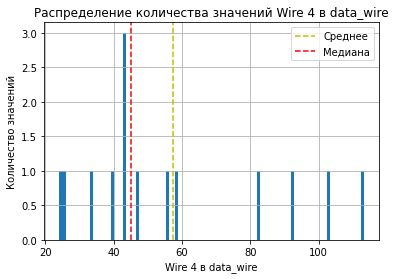

<Figure size 432x216 with 0 Axes>

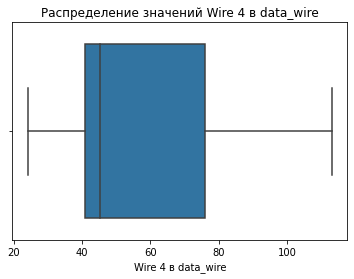

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Wire 4` =', data_wire['wire_4'].count(), 'шт.\n')
display(data_wire['wire_4'].hist(bins=100))
plt.axvline(data_wire['wire_4'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_wire['wire_4'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Wire 4 в data_wire")
plt.xlabel("Wire 4 в data_wire")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_wire,
                         x = 'wire_4',
                         orient = 'h'))
plt.title("Распределение значений Wire 4 в data_wire")
plt.xlabel("Wire 4 в data_wire")
plt.figure(figsize=(6, 3))
plt.show()

##### Wire 5


Количество значений `Wire 5` = 1 шт.



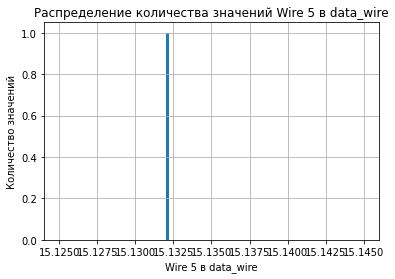

<Figure size 432x216 with 0 Axes>

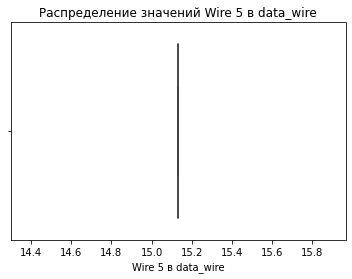

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Wire 5` =', data_wire['wire_5'].count(), 'шт.\n')
display(data_wire['wire_5'].hist(bins=100,
                                 range = (15.125, 15.145)))
plt.title("Распределение количества значений Wire 5 в data_wire")
plt.xlabel("Wire 5 в data_wire")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_wire,
                         x = 'wire_5',
                         orient = 'h'))
plt.title("Распределение значений Wire 5 в data_wire")
plt.xlabel("Wire 5 в data_wire")
plt.figure(figsize=(6, 3))
plt.show()

##### Wire 6


Количество значений `Wire 6` = 73 шт.



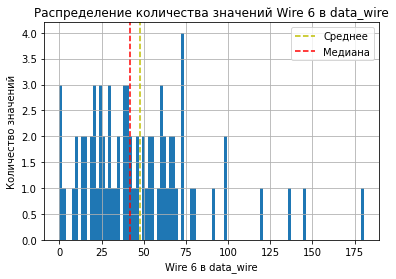

<Figure size 432x216 with 0 Axes>

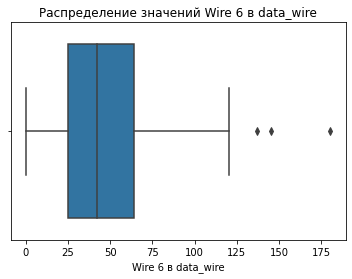

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Wire 6` =', data_wire['wire_6'].count(), 'шт.\n')
display(data_wire['wire_6'].hist(bins=100))
plt.axvline(data_wire['wire_6'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_wire['wire_6'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Wire 6 в data_wire")
plt.xlabel("Wire 6 в data_wire")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_wire,
                         x = 'wire_6',
                         orient = 'h'))
plt.title("Распределение значений Wire 6 в data_wire")
plt.xlabel("Wire 6 в data_wire")
plt.figure(figsize=(6, 3))
plt.show()

##### Wire 7


Количество значений `Wire 7` = 11 шт.



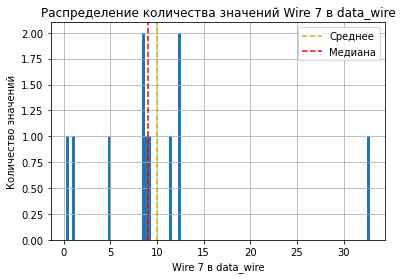

<Figure size 432x216 with 0 Axes>

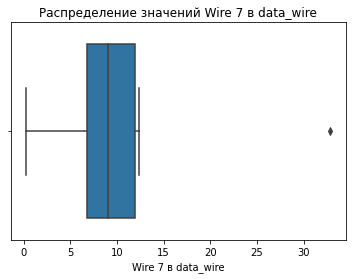

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Wire 7` =', data_wire['wire_7'].count(), 'шт.\n')
display(data_wire['wire_7'].hist(bins=100))
plt.axvline(data_wire['wire_7'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_wire['wire_7'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Wire 7 в data_wire")
plt.xlabel("Wire 7 в data_wire")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_wire,
                         x = 'wire_7',
                         orient = 'h'))
plt.title("Распределение значений Wire 7 в data_wire")
plt.xlabel("Wire 7 в data_wire")
plt.figure(figsize=(6, 3))
plt.show()

##### Wire 8


Количество значений `Wire 8` = 19 шт.



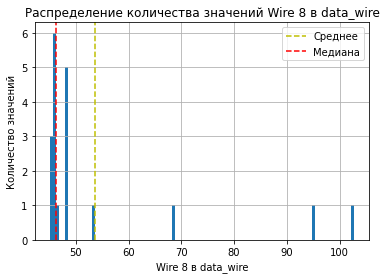

<Figure size 432x216 with 0 Axes>

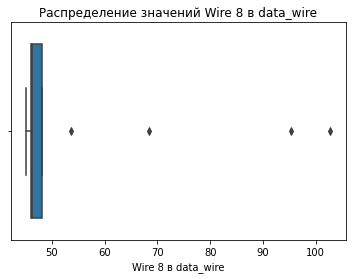

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Wire 8` =', data_wire['wire_8'].count(), 'шт.\n')
display(data_wire['wire_8'].hist(bins=100))
plt.axvline(data_wire['wire_8'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_wire['wire_8'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Wire 8 в data_wire")
plt.xlabel("Wire 8 в data_wire")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_wire,
                         x = 'wire_8',
                         orient = 'h'))
plt.title("Распределение значений Wire 8 в data_wire")
plt.xlabel("Wire 8 в data_wire")
plt.figure(figsize=(6, 3))
plt.show()

##### Wire 9


Количество значений `Wire 9` = 29 шт.



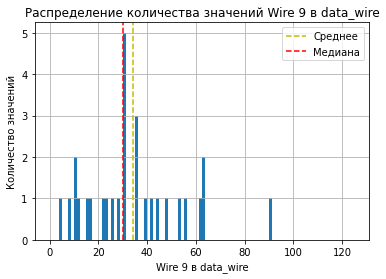

<Figure size 432x216 with 0 Axes>

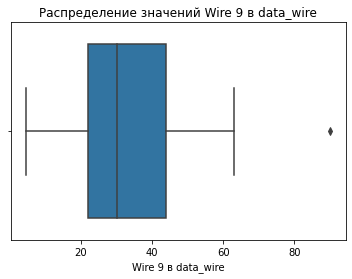

<Figure size 432x216 with 0 Axes>

In [ ]:
print('\nКоличество значений `Wire 9` =', data_wire['wire_9'].count(), 'шт.\n')
display(data_wire['wire_9'].hist(bins=100,
                                 range = (0, 125)))
plt.axvline(data_wire['wire_9'].mean(),
            ls='--',
            color='y',
            label='Среднее')
plt.axvline(data_wire['wire_9'].median(),
            ls='--',
            color='r',
            label='Медиана')
plt.legend()
plt.title("Распределение количества значений Wire 9 в data_wire")
plt.xlabel("Wire 9 в data_wire")
plt.ylabel("Количество значений")
plt.figure(figsize=(6, 3))
plt.show()
display(ax = sns.boxplot(data = data_wire,
                         x = 'wire_9',
                         orient = 'h'))
plt.title("Распределение значений Wire 9 в data_wire")
plt.xlabel("Wire 9 в data_wire")
plt.figure(figsize=(6, 3))
plt.show()

### Вывод

Артефактов нет.

Наблюдается несколько выбросов.

Уточнить у заказчика пределы нормальных значений.

Количество строк в таблицах не одинаковое. Но количество исследуемых партий равны и составляют 3241 шт.

## Уточненные вопросы

Проект:
1. Целевая переменная - итоговая (последняя) температура по партии
1. Партии с пропусками в целевой переменной убираем
1. Признаки: первая температура по партии, присадки, газ и т.д.
1. Все партии с отсутствием температур/присадок/проволки/газа отбрасываем. Хотябы одно должно быть
1. Метрика MAE
   	* 8.7 < MAE         — 0 sp
   	* 7.6 < MAE ≤ 8.7   — 4 sp
   	* 6.8 < MAE ≤ 7.6   — 4.5 sp
   	* 6.3 < MAE ≤ 6.8   — 5 sp
   	* 6.0 < MAE ≤ 6.3   — 5.5 sp
   	* MAE ≤ 6.0         — 6 sp

Данные:
1. Таблицы bulk_time, wire_time некорректные
2. Время нагрева электродов можно использовать
2. Пропуски в присадках - заполняем нулём, присадок не было
2. За выбросы считать только самые явные. Удаление всей партии с выбросами, либо заполнение соседними значениями
2. Несколько партий с температурой плавления ниже паспортной - обозначить новым признаком
2. Промежуточные температуры не используем
2. Единица измерения партии - ковш, всегда примерно одинаковый
2. Газ - признак на всю партию сразу
2. Присадки, мощность и энергия на каждое измерение - суммируем. Присадки для всей партии,суммарное bulk_1, суммарное bulk_2 и т.д.
2. Генерация новых признаков:
    * полная мощность - корень из сумм квадратов активной и реактивной мощностей
    * энергия = полная мощность * время
    * время нагрева, когда электроды были активны
    * полная масса всех присадок
    * первая температура
2. Время года, время суток не смотрим и другие производственные факторы тоже

Отчет:
1. Сделать широкую таблицу, одна строка - одна партия, задача регрессии
2. Random state 29082022
3. После обработки получится примерно 2500 строк
3. Обязательная проверка на коллинеарность перед моделированием
3. Нейросеть сеть - ReLU на последнем слое
3. Обязательна кроссвалидация
3. На тест применяется только модель с лучшим результатом на трейне
3. Размер теста - 0.2

## Подготовка данных

#### Суммируем мощности 

Приведем табличку к виду одна партия (key) одна строка.

In [ ]:
df = pd.pivot_table(data_arc,
                    values=['активная_мощность',
                            'реактивная_мощность'],
                    index='key',
                    aggfunc={'активная_мощность': np.sum,
                             'реактивная_мощность': np.sum}
                   )
df.columns = ['активная_мощность_sum',
              'реактивная_мощность_sum']

Посчитаем полную мощность по каждой партии.

In [ ]:
df['полная_мощность'] = np.sqrt(df['активная_мощность_sum']**2 + df['реактивная_мощность_sum']**2)
print(df.sample(15,
                random_state = random_state))
print('\nРазмер таблички', df.shape)

      активная_мощность_sum  реактивная_мощность_sum  полная_мощность
key                                                                  
305                2.389292                 1.628302         2.891381
2250               0.907198                 0.885429         1.267672
1661               3.363870                 2.303999         4.077258
1148               4.344626                 3.344148         5.482618
163                5.666551                 4.015908         6.945309
1195               3.431368                 2.496829         4.243636
579                0.736672                 0.492829         0.886322
456                3.022668                 2.332923         3.818252
2576               3.890391                 2.751119         4.764851
2479               2.836741                 2.120283         3.541567
3223               2.650056                 1.772470         3.188173
3124               4.058992                 2.660642         4.853291
1750               2

### Время

Удалим из таблицы партии у которы нет финального замера или только один замер температуры.

In [ ]:
not_target = []
for key in list(data_temp['key'].unique()):
    try:
        if ((data_temp[data_temp['key'] == key]['время_замера'].max() < 
            data_arc[data_arc['key'] == key]['конец_нагрева_дугой'].max()) or
           (data_temp[data_temp['key'] == key]['время_замера'].max() == 
            data_temp[data_temp['key'] == key]['время_замера'].min())):
            not_target.append(key)
    except:
        not_target.append(key)
print('\nКоличество партий без целевого значения =', len(not_target))
print('\nРазмер таблички data_temp', data_temp.shape, '\n')

data_temp = data_temp.query('key not in @not_target')
data_temp = data_temp.dropna()
data_temp.info()


Количество партий без целевого значения = 871

Размер таблички data_temp (12999, 3) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11674 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           11674 non-null  int64         
 1   время_замера  11674 non-null  datetime64[ns]
 2   температура   11674 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 364.8 KB


Выделим время первого и последнего замера по каждой партии.

In [ ]:
data_temp_time = pd.pivot_table(data_temp,
                                values='время_замера',
                                index='key',
                                aggfunc={'время_замера': [np.min,
                                                          np.max]})
data_temp_time.columns = ['время_замера_конеч',
                          'время_замера_начал']
data_temp_time['время_замера_разница'] = data_temp_time['время_замера_конеч'] - data_temp_time['время_замера_начал']
data_temp_time.sort_values('время_замера_разница',
                           ascending=False)

,время_замера_конеч,время_замера_начал,время_замера_разница
key,,,
1689,2019-07-02 22:00:38,2019-07-02 15:28:21,0 days 06:32:17
2108,2019-07-23 19:58:23,2019-07-23 14:09:40,0 days 05:48:43
1958,2019-07-18 02:38:03,2019-07-17 21:22:15,0 days 05:15:48
801,2019-06-02 04:53:02,2019-06-02 01:20:29,0 days 03:32:33
1881,2019-07-09 10:43:08,2019-07-09 07:12:25,0 days 03:30:43
...,...,...,...
1105,2019-06-12 17:17:42,2019-06-12 17:13:11,0 days 00:04:31
151,2019-05-09 02:08:56,2019-05-09 02:04:33,0 days 00:04:23
600,2019-05-25 12:11:49,2019-05-25 12:07:31,0 days 00:04:18


### Температуры
Сформируем столбцы с начальной и конечной температурами на основе времени и сохраним их в data_temp_dif.

In [ ]:
data_temp

,key,время_замера,температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


In [ ]:
time_min_list = list(data_temp_time['время_замера_начал'])
time_max_list = list(data_temp_time['время_замера_конеч'])

data_temp_min_temp = data_temp.query('время_замера in @time_min_list ')
data_temp_min_temp = data_temp_min_temp.set_index('key')

data_temp_max_temp = data_temp.query('время_замера in @time_max_list ')
data_temp_max_temp = data_temp_max_temp.set_index('key')

data_temp_dif = data_temp_min_temp
data_temp_dif.columns = ['время_замера','температура_начал']
data_temp_dif['температура_конеч'] = data_temp_max_temp['температура']

data_temp_dif['температура_разница'] = data_temp_dif['температура_конеч'] - data_temp_dif['температура_начал']
data_temp_dif.sort_values('температура_разница',
                          ascending=False)

,время_замера,температура_начал,температура_конеч,температура_разница
key,,,,
1817,2019-07-06 23:17:28,1591.0,1696.0,105.0
1525,2019-06-27 07:25:05,1587.0,1681.0,94.0
45,2019-05-04 23:06:36,1538.0,1621.0,83.0
512,2019-05-22 11:08:02,1520.0,1597.0,77.0
1664,2019-07-01 19:08:06,1530.0,1603.0,73.0
...,...,...,...,...
1988,2019-07-19 07:23:43,1652.0,1582.0,-70.0
115,2019-05-07 11:01:24,1635.0,1547.0,-88.0
2110,2019-07-23 17:42:36,1645.0,1551.0,-94.0


In [ ]:
data_temp_dif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   время_замера         2344 non-null   datetime64[ns]
 1   температура_начал    2344 non-null   float64       
 2   температура_конеч    2344 non-null   float64       
 3   температура_разница  2344 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 91.6 KB


### Сыпучие и проволочные материалы

Согласно уточненным вопросам все Nan в data_bulk и wire заменяем на 0.

In [ ]:
data_bulk = data_bulk.fillna(0)
data_bulk['bulk_sum'] = data_bulk.iloc[:,1:].sum(axis = 1)
display(data_bulk.head(3))
data_wire = data_wire.fillna(0)
data_wire['wire_sum'] = data_wire.iloc[:,1:].sum(axis = 1)
display(data_wire.head(3))

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157


### Пропуски в целевой переменной

В оставшихся таблицах преобразуем столбцы key в index.

In [ ]:
data_bulk = data_bulk.set_index('key')
print(data_bulk.columns)
data_gas = data_gas.set_index('key')
print(data_gas.columns)
data_wire = data_wire.set_index('key')
print(data_wire.columns)

Index(['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
       'bulk_14', 'bulk_15', 'bulk_sum'],
      dtype='object')
Index(['газ_1'], dtype='object')
Index(['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7',
       'wire_8', 'wire_9', 'wire_sum'],
      dtype='object')


Объединим таблички с удалением строк без финального замера температуры.

In [ ]:
df = pd.concat([df,
                data_temp_time,
                data_temp_dif,
                data_bulk,
                data_gas,
                data_wire],
               axis = 1,
               sort = False)
df = df.dropna(subset = ['температура_конеч'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   активная_мощность_sum    2344 non-null   float64        
 1   реактивная_мощность_sum  2344 non-null   float64        
 2   полная_мощность          2344 non-null   float64        
 3   время_замера_конеч       2344 non-null   datetime64[ns] 
 4   время_замера_начал       2344 non-null   datetime64[ns] 
 5   время_замера_разница     2344 non-null   timedelta64[ns]
 6   время_замера             2344 non-null   datetime64[ns] 
 7   температура_начал        2344 non-null   float64        
 8   температура_конеч        2344 non-null   float64        
 9   температура_разница      2344 non-null   float64        
 10  bulk_1                   2283 non-null   float64        
 11  bulk_2                   2283 non-null   float64        
 12  bulk_3              

### Энергия

Посчитаем энергию, затраченную на каждую партию.

In [ ]:
df['энергия'] = df['полная_мощность'] * df['время_замера_разница']

Проверим коллинеарность и отсутсвие зависимостей между признаками.

In [ ]:
df = df.drop('wire_5', axis=1) # удалим, а то всего 1 значение, и портит матрицу корреляции

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   активная_мощность_sum    2344 non-null   float64        
 1   реактивная_мощность_sum  2344 non-null   float64        
 2   полная_мощность          2344 non-null   float64        
 3   время_замера_конеч       2344 non-null   datetime64[ns] 
 4   время_замера_начал       2344 non-null   datetime64[ns] 
 5   время_замера_разница     2344 non-null   timedelta64[ns]
 6   время_замера             2344 non-null   datetime64[ns] 
 7   температура_начал        2344 non-null   float64        
 8   температура_конеч        2344 non-null   float64        
 9   температура_разница      2344 non-null   float64        
 10  bulk_1                   2283 non-null   float64        
 11  bulk_2                   2283 non-null   float64        
 12  bulk_3              

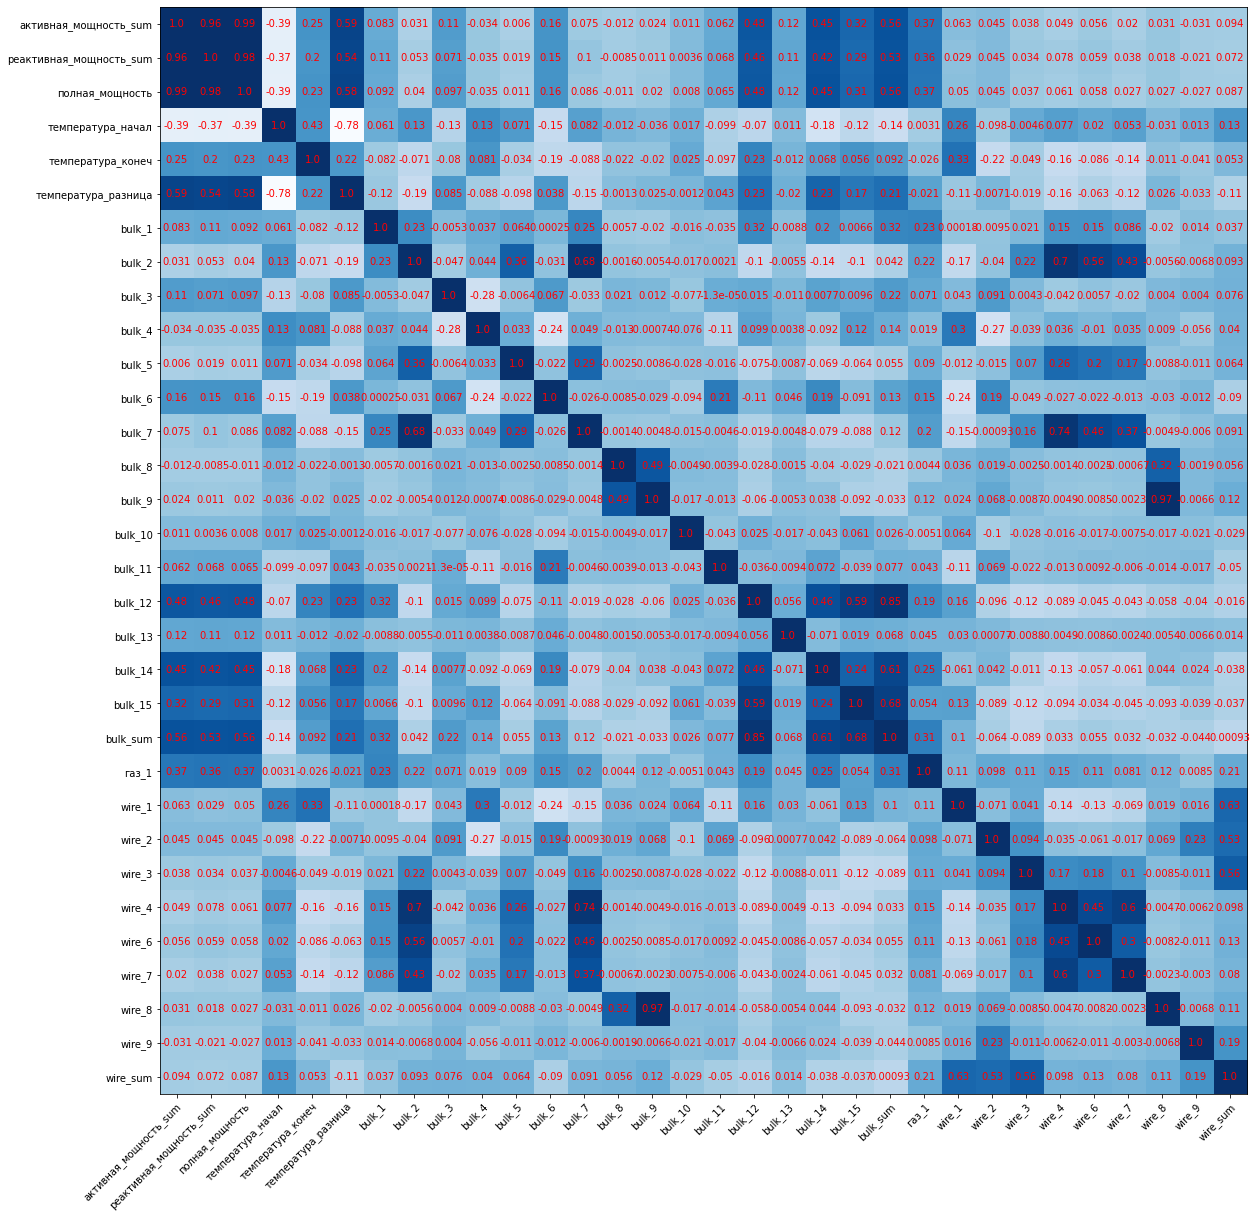

In [ ]:
corr_heatmap = df.corr()

fig, ax = plt.subplots(figsize = (20, 20))
ax.set_xticks(np.arange(len(corr_heatmap.index)))
ax.set_yticks(np.arange(len(corr_heatmap.index)))

ax.set_xticklabels(corr_heatmap.index)
ax.set_yticklabels(corr_heatmap.index)

plt.setp(ax.get_xticklabels(),
         rotation = 45,
         ha="right",
         rotation_mode = "anchor")

data = corr_heatmap.values

for i in range(len(corr_heatmap.index)):
    for j in range(len(corr_heatmap.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha = "center",
                       va = "center",
                       color = "r")
        
im = ax.imshow(corr_heatmap.corr(),
               cmap = 'Blues'
              )

Из карты корреляции видны очень сильные прямопропоциональные зависимости между

 * активная_мощность_sum, реактивная_мощность_sum и полная_мощность
 * bulk_9 и wire_8

Оставим только `полная_мощность` и `bulk_9`.

In [ ]:
df = df.drop(['активная_мощность_sum',
              'реактивная_мощность_sum',
              'wire_8'],
             axis = 1)

Посмотрим как признаки влияют на конечный результат.

In [ ]:
df.corr()['температура_конеч'].abs().sort_values(ascending=False)

температура_конеч      1.000000
температура_начал      0.428674
wire_1                 0.325706
полная_мощность        0.232113
bulk_12                0.231292
температура_разница    0.223294
wire_2                 0.220213
bulk_6                 0.191790
wire_4                 0.162379
wire_7                 0.139443
bulk_11                0.097292
bulk_sum               0.092196
bulk_7                 0.088391
wire_6                 0.085760
bulk_1                 0.081844
bulk_4                 0.081157
bulk_3                 0.080077
bulk_2                 0.070562
bulk_14                0.067566
bulk_15                0.056093
wire_sum               0.053441
wire_3                 0.048721
wire_9                 0.040600
bulk_5                 0.034210
газ_1                  0.026028
bulk_10                0.025319
bulk_8                 0.022394
bulk_9                 0.019899
bulk_13                0.011986
Name: температура_конеч, dtype: float64

Явных подсказчиков правильных ответов не наблюдается.

Если потребуется увеличивать точность моделей предсказания можно будет удалять метрики по мере роста корреляции, начиная с самой маленькой по модулю.

## Настройка моделей предсказания

Разделим данные на обучающую и тестовую выборки к соотношению 80/20.
Количество кросс-валидаций зададим равным 10.

In [ ]:
features = df.drop('температура_конеч', axis = 1)
target = df['температура_конеч']

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   полная_мощность       2344 non-null   float64        
 1   время_замера_конеч    2344 non-null   datetime64[ns] 
 2   время_замера_начал    2344 non-null   datetime64[ns] 
 3   время_замера_разница  2344 non-null   timedelta64[ns]
 4   время_замера          2344 non-null   datetime64[ns] 
 5   температура_начал     2344 non-null   float64        
 6   температура_разница   2344 non-null   float64        
 7   bulk_1                2283 non-null   float64        
 8   bulk_2                2283 non-null   float64        
 9   bulk_3                2283 non-null   float64        
 10  bulk_4                2283 non-null   float64        
 11  bulk_5                2283 non-null   float64        
 12  bulk_6                2283 non-null   float64        
 13  bul

Формат времени мешает работе некоторых моделей.

К тому же есть дополнительное условие "Время года, время суток не смотрим", а значит и учитывать в моделях не будем.

Ну и если в ковш ничего не добавляли, тоже удаляем.

In [ ]:
features = features.drop('время_замера', axis = 1)
features = features.drop('время_замера_конеч', axis = 1)
features = features.drop('время_замера_начал', axis = 1)
features = features.drop('время_замера_разница', axis = 1)
features = features.drop('энергия', axis = 1) # не хочет энергия менять формат данных
features = features.drop('температура_разница', axis = 1) # нечего ее прибавлять к начальной для получения конечной

features = features.drop(features[(features.bulk_sum == 0) & 
                                  (features.газ_1 == 0) & 
                                  (features.wire_sum == 0)].index)

features = features.fillna(0)

Удалим параметры, корреляция которых с прогнозируемым признаком менее 5%.

In [ ]:
features = features.drop('wire_3', axis = 1)
features = features.drop('wire_9', axis = 1)
features = features.drop('bulk_5', axis = 1)
features = features.drop('bulk_10', axis = 1)
features = features.drop('bulk_8', axis = 1)
features = features.drop('bulk_9', axis = 1)
features = features.drop('bulk_13', axis = 1)

Удалим еще 5%. Оставим параметры, корреляция которых с прогнозируемым признаком более 10%.

In [ ]:
features = features.drop('bulk_11', axis = 1)
features = features.drop('bulk_7', axis = 1)
features = features.drop('wire_6', axis = 1)
features = features.drop('bulk_1', axis = 1)
features = features.drop('bulk_4', axis = 1)
features = features.drop('bulk_3', axis = 1)
features = features.drop('bulk_2', axis = 1)
features = features.drop('bulk_14', axis = 1)
features = features.drop('bulk_15', axis = 1)

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            test_size = 0.2, 
                                                                            random_state = random_state)

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   полная_мощность    2344 non-null   float64
 1   температура_начал  2344 non-null   float64
 2   bulk_6             2344 non-null   float64
 3   bulk_12            2344 non-null   float64
 4   bulk_sum           2344 non-null   float64
 5   газ_1              2344 non-null   float64
 6   wire_1             2344 non-null   float64
 7   wire_2             2344 non-null   float64
 8   wire_4             2344 non-null   float64
 9   wire_7             2344 non-null   float64
 10  wire_sum           2344 non-null   float64
dtypes: float64(11)
memory usage: 284.3 KB


### CatBoostRegressor

In [ ]:
%%time

regressor = CatBoostRegressor(verbose = False,
                              random_state = random_state)
mae_cbr = (cross_val_score(regressor, 
                           features_train, 
                           target_train, 
                           cv = cv,
                           scoring = 'neg_mean_absolute_error').mean() * -1)
print('\nЛучшие найденные параметры:\n')
best_parameters_cbr = CatBoostRegressor(verbose=False, 
                                        random_state = random_state).fit(features_train,
                                                                         target_train).get_all_params()
display(best_parameters_cbr)
print('\nСреднее значение MAE на кроссвалидации у CatBoostRegressor =', mae_cbr, '\n')


Лучшие найденные параметры:



{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 29082022,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04521799832582474,
 'score_function': 'Cosine',
 'tas


Среднее значение MAE на кроссвалидации у CatBoostRegressor = 6.235551794804569 

CPU times: user 56.1 s, sys: 4.71 s, total: 1min
Wall time: 35.4 s


Отмасштабируем признаки.

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

### DummyRegressor

Посчитаем простенькую модель на медианах, с которой и будем сравнивать остальные.

In [ ]:
%%time

dummy = DummyRegressor(strategy="median")
dummy.fit(features_train,
          target_train)
mae_dummy = mean_absolute_error(target_train,
                                dummy.predict(features_train)) 
print('\nСреднее значение MAE на кроссвалидации у DummyRegressor =', mae_dummy, '\n')


Среднее значение MAE на кроссвалидации у DummyRegressor = 9.747733333333333 

CPU times: user 4.05 ms, sys: 2 µs, total: 4.05 ms
Wall time: 4.8 ms


### LGBMRegressor

In [ ]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[x for x in range(29,34)],
                'learning_rate':[x/100 for x in range(6, 11)],
                'random_state':[random_state]}]
clf = GridSearchCV(regressor,
                   hyperparams,
                   scoring = 'neg_mean_absolute_error',
                   cv = cv)
clf.fit(features_train,
        target_train)
print('\nЛучшие найденные параметры:\n')
best_parameters_lgbmr = clf.best_params_
display(best_parameters_lgbmr)
means = clf.cv_results_['mean_test_score']
mae_lgbmr = (max(means)*-1)
print('\nСреднее значение MAE у LGBMRegressor =', mae_lgbmr, '\n')


Лучшие найденные параметры:



{'learning_rate': 0.06, 'num_leaves': 32, 'random_state': 29082022}


Среднее значение MAE у LGBMRegressor = 6.400006581890726 

CPU times: user 1min 16s, sys: 2.67 s, total: 1min 19s
Wall time: 43.8 s


### LinearRegression

In [ ]:
%%time

regressor = LinearRegression()
mae_lr = (cross_val_score(regressor,
                          features_train,
                          target_train,
                          cv = cv,
                          scoring='neg_mean_absolute_error').mean() * -1)
print('\nСреднее значение MAE на кроссвалидации у LinearRegression =', mae_lr, '\n')


Среднее значение MAE на кроссвалидации у LinearRegression = 7.9160786346494785 

CPU times: user 35.3 ms, sys: 33.2 ms, total: 68.5 ms
Wall time: 54.5 ms


### RandomForestRegressor

In [ ]:
%%time

regressor = RandomForestRegressor() 
hyperparams = [{'criterion':[#'mae',
                             'mse'
                            ],
                'n_estimators':[x for x in range(1100, 1301, 100)],
                'max_depth':[x for x in range(9, 13, 2)],
                'random_state':[random_state]}]
clf = GridSearchCV(regressor,
                   hyperparams,
                   scoring = 'neg_mean_absolute_error',
                   cv = cv)
clf.fit(features_train,
        target_train)
print('\nЛучшие найденные параметры:\n')
best_parameters_rfr = clf.best_params_
display(best_parameters_rfr)
means = clf.cv_results_['mean_test_score']
mae_rfr = (max(means)*-1)
print('\nСреднее значение MAE у RandomForestRegressor =', mae_rfr, '\n')


Лучшие найденные параметры:



{'criterion': 'mse',
 'max_depth': 11,
 'n_estimators': 1200,
 'random_state': 29082022}


Среднее значение MAE у RandomForestRegressor = 6.2893176261428385 

CPU times: user 9min 39s, sys: 2.09 s, total: 9min 41s
Wall time: 9min 43s


### XGBRegressor

In [ ]:
%%time

regressor = XGBRegressor() 
hyperparams = [{'learning_rate':[x/100 for x in range(5, 15)],
                'min_child_weight':[30, 40],
                'max_depth':[5, 10],
                'random_state':[random_state],
                'silent':[True]}]
clf = GridSearchCV(regressor,
                   hyperparams,
                   scoring = 'neg_mean_absolute_error',
                   cv = cv)
clf.fit(features_train,
        target_train)
print('\nЛучшие найденные параметры:\n')
best_parameters_XGBR = clf.best_params_
display(best_parameters_XGBR)
means = clf.cv_results_['mean_test_score']
mae_xgbr = (max(means)*-1)
print('\nСреднее значение MAE у XGBRegressor =', mae_xgbr, '\n')


Лучшие найденные параметры:



{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 40,
 'random_state': 29082022,
 'silent': True}


Среднее значение MAE у XGBRegressor = 6.294761380108703 

CPU times: user 1min 19s, sys: 579 ms, total: 1min 19s
Wall time: 1min 19s


### Сводная таблица

In [ ]:
index = ['CatBoostRegressor',
         'DummyRegressor',
         'LGBMRegressor',
         'LinearRegression',
         'RandomForestRegressor',
         'XGBRegressor']
data = {'MAE_на_CV':[mae_cbr,
                     mae_dummy,
                     mae_lgbmr,
                     mae_lr,
                     mae_rfr,
                     mae_xgbr]}
pivot = pd.DataFrame(data = data,
                     index = index)
pivot['0.0 sp'] = (8.7 < pivot['MAE_на_CV'])
pivot['4.0 sp'] = (7.6 < pivot['MAE_на_CV'])
pivot['4.5 sp'] = (6.8 < pivot['MAE_на_CV'])
pivot['5.0 sp'] = (6.3 < pivot['MAE_на_CV'])
pivot['5.5 sp'] = (6.0 < pivot['MAE_на_CV'])
pivot['6.0 sp'] = (pivot['MAE_на_CV'] <= 6)
display(pivot)

,MAE_на_CV,0.0 sp,4.0 sp,4.5 sp,5.0 sp,5.5 sp,6.0 sp
CatBoostRegressor,6.235552,False,False,False,False,True,False
DummyRegressor,9.747733,True,True,True,True,True,False
LGBMRegressor,6.400007,False,False,False,True,True,False
LinearRegression,7.916079,False,True,True,True,True,False
RandomForestRegressor,6.289318,False,False,False,False,True,False
XGBRegressor,6.294761,False,False,False,False,True,False


## Тестирование моделей

### CatBoostRegressor

In [ ]:
%%time

model_cbr = CatBoostRegressor(verbose=False)
model_cbr.set_params(**best_parameters_cbr)
model_cbr.fit(features_train,
              target_train)
target_predict = model_cbr.predict(features_test)
mae_cbr_test = mean_absolute_error(target_predict,
                                   target_test)
print('\nMAE на тестовой выборке у CatBoostRegressor =', mae_cbr_test, '\n')


MAE на тестовой выборке у CatBoostRegressor = 6.230669345610362 

CPU times: user 5.17 s, sys: 349 ms, total: 5.52 s
Wall time: 2.91 s


### DummyRegressor

In [ ]:
%%time

model_dummy = DummyRegressor(strategy="median")
model_dummy.fit(features_train,
                target_train)
mae_dummy_test = mean_absolute_error(target_test,
                                     model_dummy.predict(features_test)) 
print('\nMAE на тестовой выборке у DummyRegressor =', mae_dummy_test, '\n')


MAE на тестовой выборке у DummyRegressor = 10.046908315565032 

CPU times: user 2.24 ms, sys: 5 µs, total: 2.24 ms
Wall time: 1.99 ms


### LGBMRegressor

In [ ]:
%%time

model_lgbmr = LGBMRegressor()
model_lgbmr.set_params(**best_parameters_lgbmr)
model_lgbmr.fit(features_train,
                target_train)
target_predict = model_lgbmr.predict(features_test)
mae_lgbmr_test = mean_absolute_error(target_predict,
                                     target_test)
print('\nMAE на тестовой выборке у LGBMRegressor =', mae_lgbmr_test, '\n')


MAE на тестовой выборке у LGBMRegressor = 6.336854008861444 

CPU times: user 186 ms, sys: 9.03 ms, total: 195 ms
Wall time: 204 ms


### LinearRegression

In [ ]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train,
             target_train)
target_predict = model_lr.predict(features_test)
mae_lr_test = mean_absolute_error(target_predict,
                                  target_test)
print('\nMAE на тестовой выборке у LinearRegression =', mae_lr_test, '\n')


MAE на тестовой выборке у LinearRegression = 8.207072797103576 

CPU times: user 4.25 ms, sys: 3.99 ms, total: 8.24 ms
Wall time: 6.61 ms


### RandomForestRegressor

In [ ]:
%%time

model_rfr = RandomForestRegressor()
model_rfr.set_params(**best_parameters_rfr)
model_rfr.fit(features_train,
              target_train)
target_predict = model_rfr.predict(features_test)
mae_rfr_test = mean_absolute_error(target_predict,
                                   target_test)
print('\nMAE на тестовой выборке у RandomForestRegressor =', mae_rfr_test, '\n')


MAE на тестовой выборке у RandomForestRegressor = 6.205561016151124 

CPU times: user 13.9 s, sys: 128 ms, total: 14 s
Wall time: 18.6 s


### XGBRegressor

In [ ]:
%%time

model_xgbr = XGBRegressor()
model_xgbr.set_params(**best_parameters_XGBR)
model_xgbr.fit(features_train,
               target_train)
target_predict = model_xgbr.predict(features_test)
mae_xgbr_test = mean_absolute_error(target_predict,
                                    target_test)
print('\nMAE на тестовой выборке у XGBRegressor =', mae_xgbr_test, '\n')


MAE на тестовой выборке у XGBRegressor = 6.424387462103545 

CPU times: user 292 ms, sys: 6 µs, total: 292 ms
Wall time: 292 ms


### Сводная таблица

In [ ]:
index = ['CatBoostRegressor',
         'DummyRegressor',
         'LGBMRegressor',
         'LinearRegression',
         'RandomForestRegressor',
         'XGBRegressor']
data = {'MAE_на_CV':[mae_cbr,
                     mae_dummy,
                     mae_lgbmr,
                     mae_lr,
                     mae_rfr,
                     mae_xgbr],
        'MAE_на_тесте':[mae_cbr_test,
                        mae_dummy_test,
                        mae_lgbmr_test,
                        mae_lr_test,
                        mae_rfr_test,
                        mae_xgbr_test]}
pivot = pd.DataFrame(data = data,
                     index = index)
pivot['0.0 sp'] = (8.7 < pivot['MAE_на_тесте'])
pivot['4.0 sp'] = (7.6 < pivot['MAE_на_тесте'])
pivot['4.5 sp'] = (6.8 < pivot['MAE_на_тесте'])
pivot['5.0 sp'] = (6.3 < pivot['MAE_на_тесте'])
pivot['5.5 sp'] = (6.0 < pivot['MAE_на_тесте'])
pivot['6.0 sp'] = (pivot['MAE_на_тесте'] <= 6)
pivot

,MAE_на_CV,MAE_на_тесте,0.0 sp,4.0 sp,4.5 sp,5.0 sp,5.5 sp,6.0 sp
CatBoostRegressor,6.235552,6.230669,False,False,False,False,True,False
DummyRegressor,9.747733,10.046908,True,True,True,True,True,False
LGBMRegressor,6.400007,6.336854,False,False,False,True,True,False
LinearRegression,7.916079,8.207073,False,True,True,True,True,False
RandomForestRegressor,6.289318,6.205561,False,False,False,False,True,False
XGBRegressor,6.294761,6.424387,False,False,False,True,True,False


# Вывод

Цель проекта "Построить модель, которая предскажет температуру стали" достигнута.

В ходе проекта были исследованы следующие регрессионные модели:

* CatBoostRegressor
* LGBMRegressor
* LinearRegression
* RandomForestRegressor
* XGBRegressor

Все модели показали минимальнонеобходимую точность предсказания.

Лучшей моделью при настройках показала себя CatBoostRegressor с погрешностью MAE = 6.2307 градусов.

Но на тестовой выборке лучший результат получился у RandomForestRegressor показав погрешность MAE = 6.2056 градусов.

LinearRegression оказалась худшей моделью из-за отсуствия необходимых нелинейных связей.

Если бы привязаться к нормам по времени процессов и объемам добавок, то точность предсказания можно еще увеличить.

Сильнее всего на предсказание финальной температуры влияют объем использованных проволочных материалов, начальная температура и полная мощность.

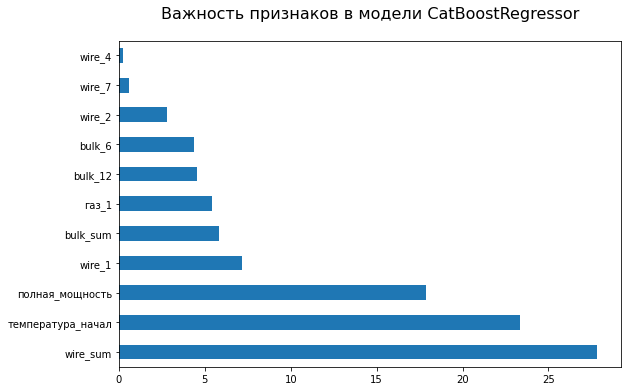

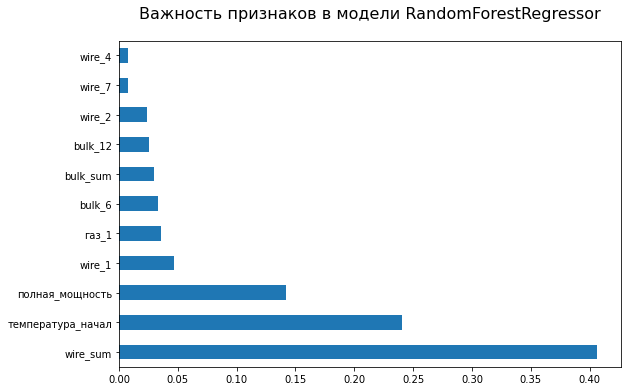

In [ ]:
importance_cbr = pd.Series(model_cbr.feature_importances_,
                           index = features.columns)
plt.figure(figsize = (9, 6))
importance_cbr.nlargest(20).plot(kind = 'barh')
plt.title('Важность признаков в модели CatBoostRegressor',
          size = 16,
          y = 1.05
          );
plt.show()

importance_rfr = pd.Series(model_rfr.feature_importances_,
                           index = features.columns)
plt.figure(figsize = (9, 6))
importance_rfr.nlargest(20).plot(kind = 'barh')
plt.title('Важность признаков в модели RandomForestRegressor',
          size = 16,
          y = 1.05
          );
plt.show()

## Отчет

### Задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Предстоит построить модель, которая предскажет температуру стали.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

    * `data_arc.csv`       — данные об электродах;
    * `data_bulk.csv`      — данные о подаче сыпучих материалов (объём);
    * `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
    * `data_gas.csv`       — данные о продувке сплава газом;
    * `data_temp.csv`      — результаты измерения температуры;
    * `data_wire.csv`      — данные о проволочных материалах (объём);
    * `data_wire_time.csv` — данные о проволочных материалах (время).

### Чек-лист по проделанной работе

#### План работ:
1.   [x] Описание проекта
2.   [x] Загрузка данных
3.   [x] Анализ данных
5.   [x] Подготовка данных
6.   [x] Выбор моделей предсказания
7.   [x] Тестирование моделей

#### Уточненные вопросы

##### Проект:
1. [x] Целевая переменная - итоговая (последняя) температура по партии
1. [x] Партии с пропусками в целевой переменной убираем
1. [x] Признаки: первая температура по партии, присадки, газ и т.д.
1. [x] Все партии с отсутствием температур/присадок/проволки/газа отбрасываем. Хотябы одно должно быть
1. [x] Метрика MAE

##### Данные:
1. [x] Таблицы bulk_time, wire_time некорректные
2. [x] Время нагрева электродов можно использовать
2. [x] Пропуски в присадках - заполняем нулём, присадок не было
2. [x] За выбросы считать только самые явные. Удаление всей партии с выбросами, либо заполнение соседними значениями
2. [ ] Несколько партий с температурой плавления ниже паспортной - обозначить новым признаком
2. [x] Промежуточные температуры не используем
2. [x] Газ - признак на всю партию сразу
2. [x] Присадки, мощность и энергия на каждое измерение - суммируем. Присадки для всей партии,суммарное bulk_1, суммарное bulk_2 и т.д.
2. Генерация новых признаков:
    * [x] полная мощность - корень из сумм квадратов активной и реактивной мощностей
    * [x] энергия = полная мощность * время
    * [x] время нагрева, когда электроды были активны
    * [x] полная масса всех присадок
    * [x] первая температура
2. [x] Время года, время суток не смотрим и другие производственные факторы тоже

##### Отчет:
1. [x] Сделать широкую таблицу, одна строка - одна партия, задача регрессии
2. [x] Random state 29082022
3. [x] После обработки получится примерно 2500 строк
3. [x] Обязательная проверка на коллинеарность перед моделированием
3. [ ] Нейросеть сеть - ReLU на последнем слое
3. [x] Обязательна кроссвалидация
3. [x] Размер теста - 0.2

* Удалось выполнить все пункты начального плана работ.
* Из дополнительных вопросов не была использована нейросеть, т.к. все рассмотренные моддели обеспечили минимальнонеобходимую точность предсказания, а 2 модели удалось настроить почти до идеального результата.
* Тяжелее всего при выполнении плана разобраться в сути производственного процесса. Информация из общедоступных источников мало помогла понять как оценить большинство предоставленных параметров.
* Ключевым шагом в решении задачи можно выделить анализ входных данных. Генерация новых признаков, корреляция между ними и настройка моделей - это чисто технические моменты работы.
* Наилучший результат при настройке показала модель CatBoostRegressor с погрешностью предсказания на тестовой выборке в 6.23 градусов.

    Лучшие найденные параметры модели:

     * 'nan_mode': 'Min',
     * 'eval_metric': 'RMSE',
     * 'iterations': 1000,
     * 'sampling_frequency': 'PerTree',
     * 'leaf_estimation_method': 'Newton',
     * 'grow_policy': 'SymmetricTree',
     * 'penalties_coefficient': 1,
     * 'boosting_type': 'Plain',
     * 'model_shrink_mode': 'Constant',
     * 'feature_border_type': 'GreedyLogSum',
     * 'bayesian_matrix_reg': 0.10000000149011612,
     * 'force_unit_auto_pair_weights': False,
     * 'l2_leaf_reg': 3,
     * 'random_strength': 1,
     * 'rsm': 1,
     * 'boost_from_average': True,
     * 'model_size_reg': 0.5,
     * 'pool_metainfo_options': {'tags': {}},
     * 'subsample': 0.800000011920929,
     * 'use_best_model': False,
     * 'random_seed': 29082022,
     * 'depth': 6,
     * 'posterior_sampling': False,
     * 'border_count': 254,
     * 'classes_count': 0,
     * 'auto_class_weights': 'None',
     * 'sparse_features_conflict_fraction': 0,
     * 'leaf_estimation_backtracking': 'AnyImprovement',
     * 'best_model_min_trees': 1,
     * 'model_shrink_rate': 0,
     * 'min_data_in_leaf': 1,
     * 'loss_function': 'RMSE',
     * 'learning_rate': 0.04521799832582474,
     * 'score_function': 'Cosine',
     * 'task_type': 'CPU',
     * 'leaf_estimation_iterations': 1,
     * 'bootstrap_type': 'MVS',
     * 'max_leaves': 64.

    Модель просчитана на признаках:
     * wire_4
     * wire_7
     * wire_2
     * bulk_6
     * bulk_12
     * газ_1
     * bulk_sum
     * wire_1
     * полная_мощность
     * температура_начал
     * wire_sum